In [2]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

import json

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

# importing my model functions for analysis
from psi_transmission.model import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# import all the data
nominal_data_list, jpsu_data_list, jpti_data_list, disk_data_list, gd01_data_list, gd03_data_list, epsu_data_list = load_all_data()

# Clarifying the Monitor Detector Sequence

Schematic of PSI source and beamlines:

![](../misc/psi_source.png)
![](jonahberean/psi_transmission/misc/psi_source.png)

The monitor detector was positioned on West-2 at the opening to the UCN storage vessel

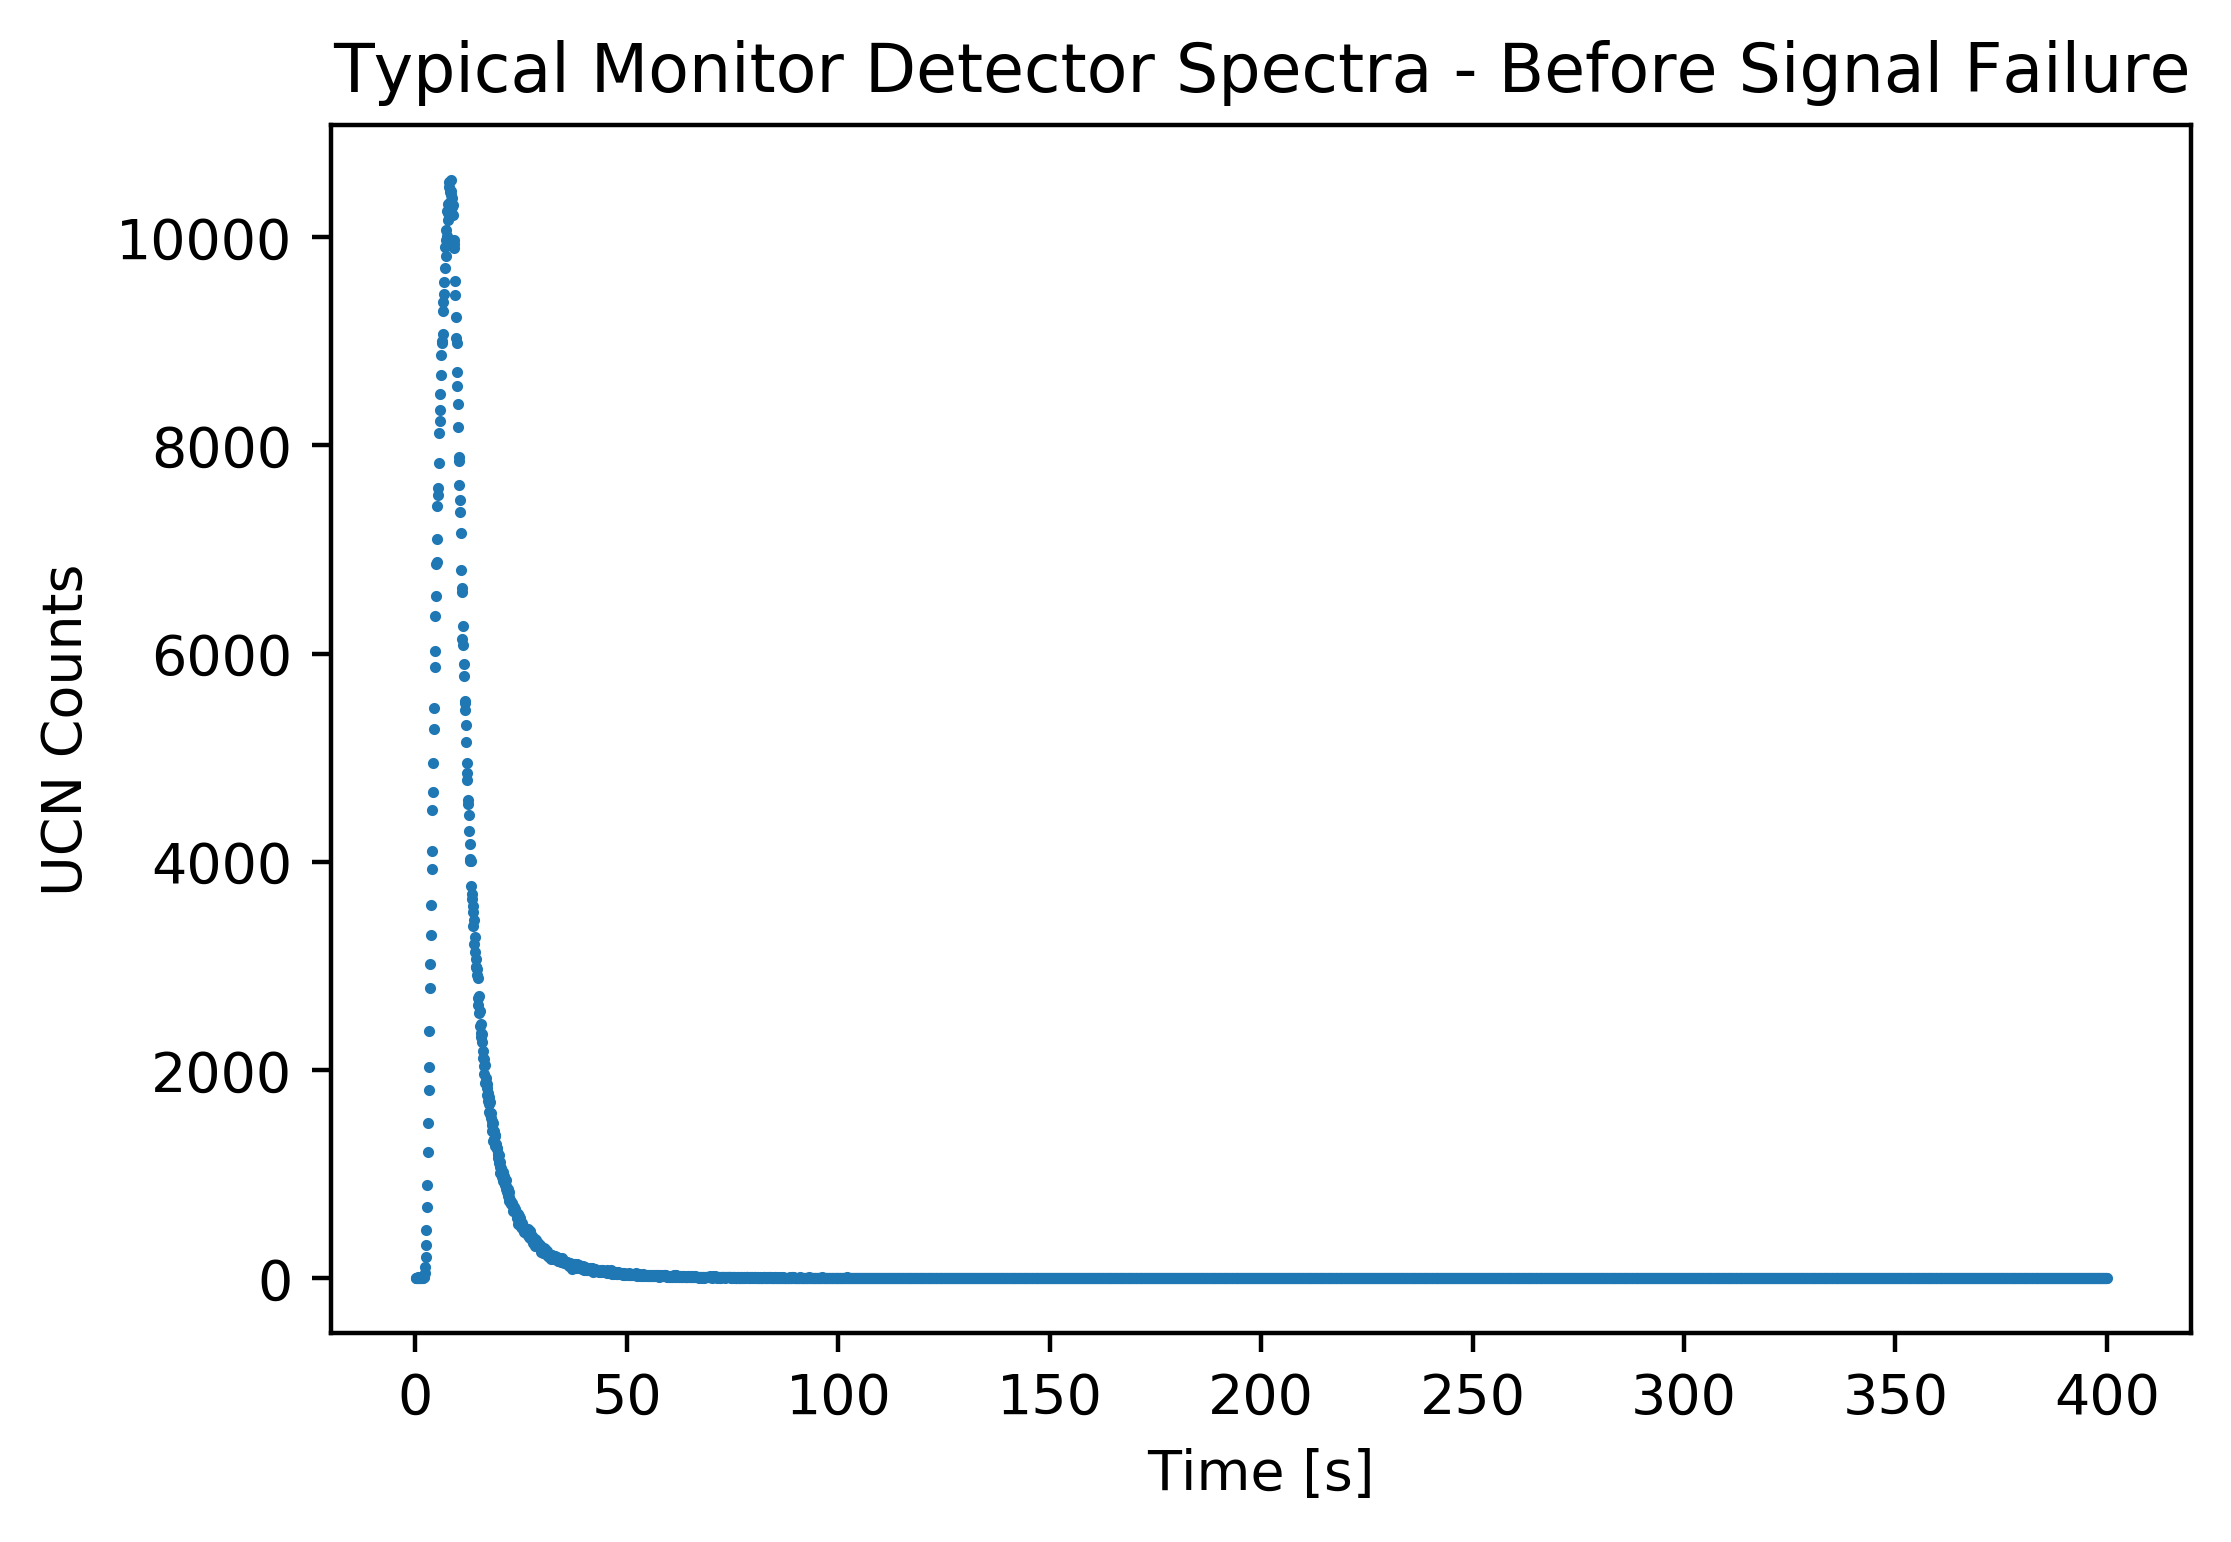

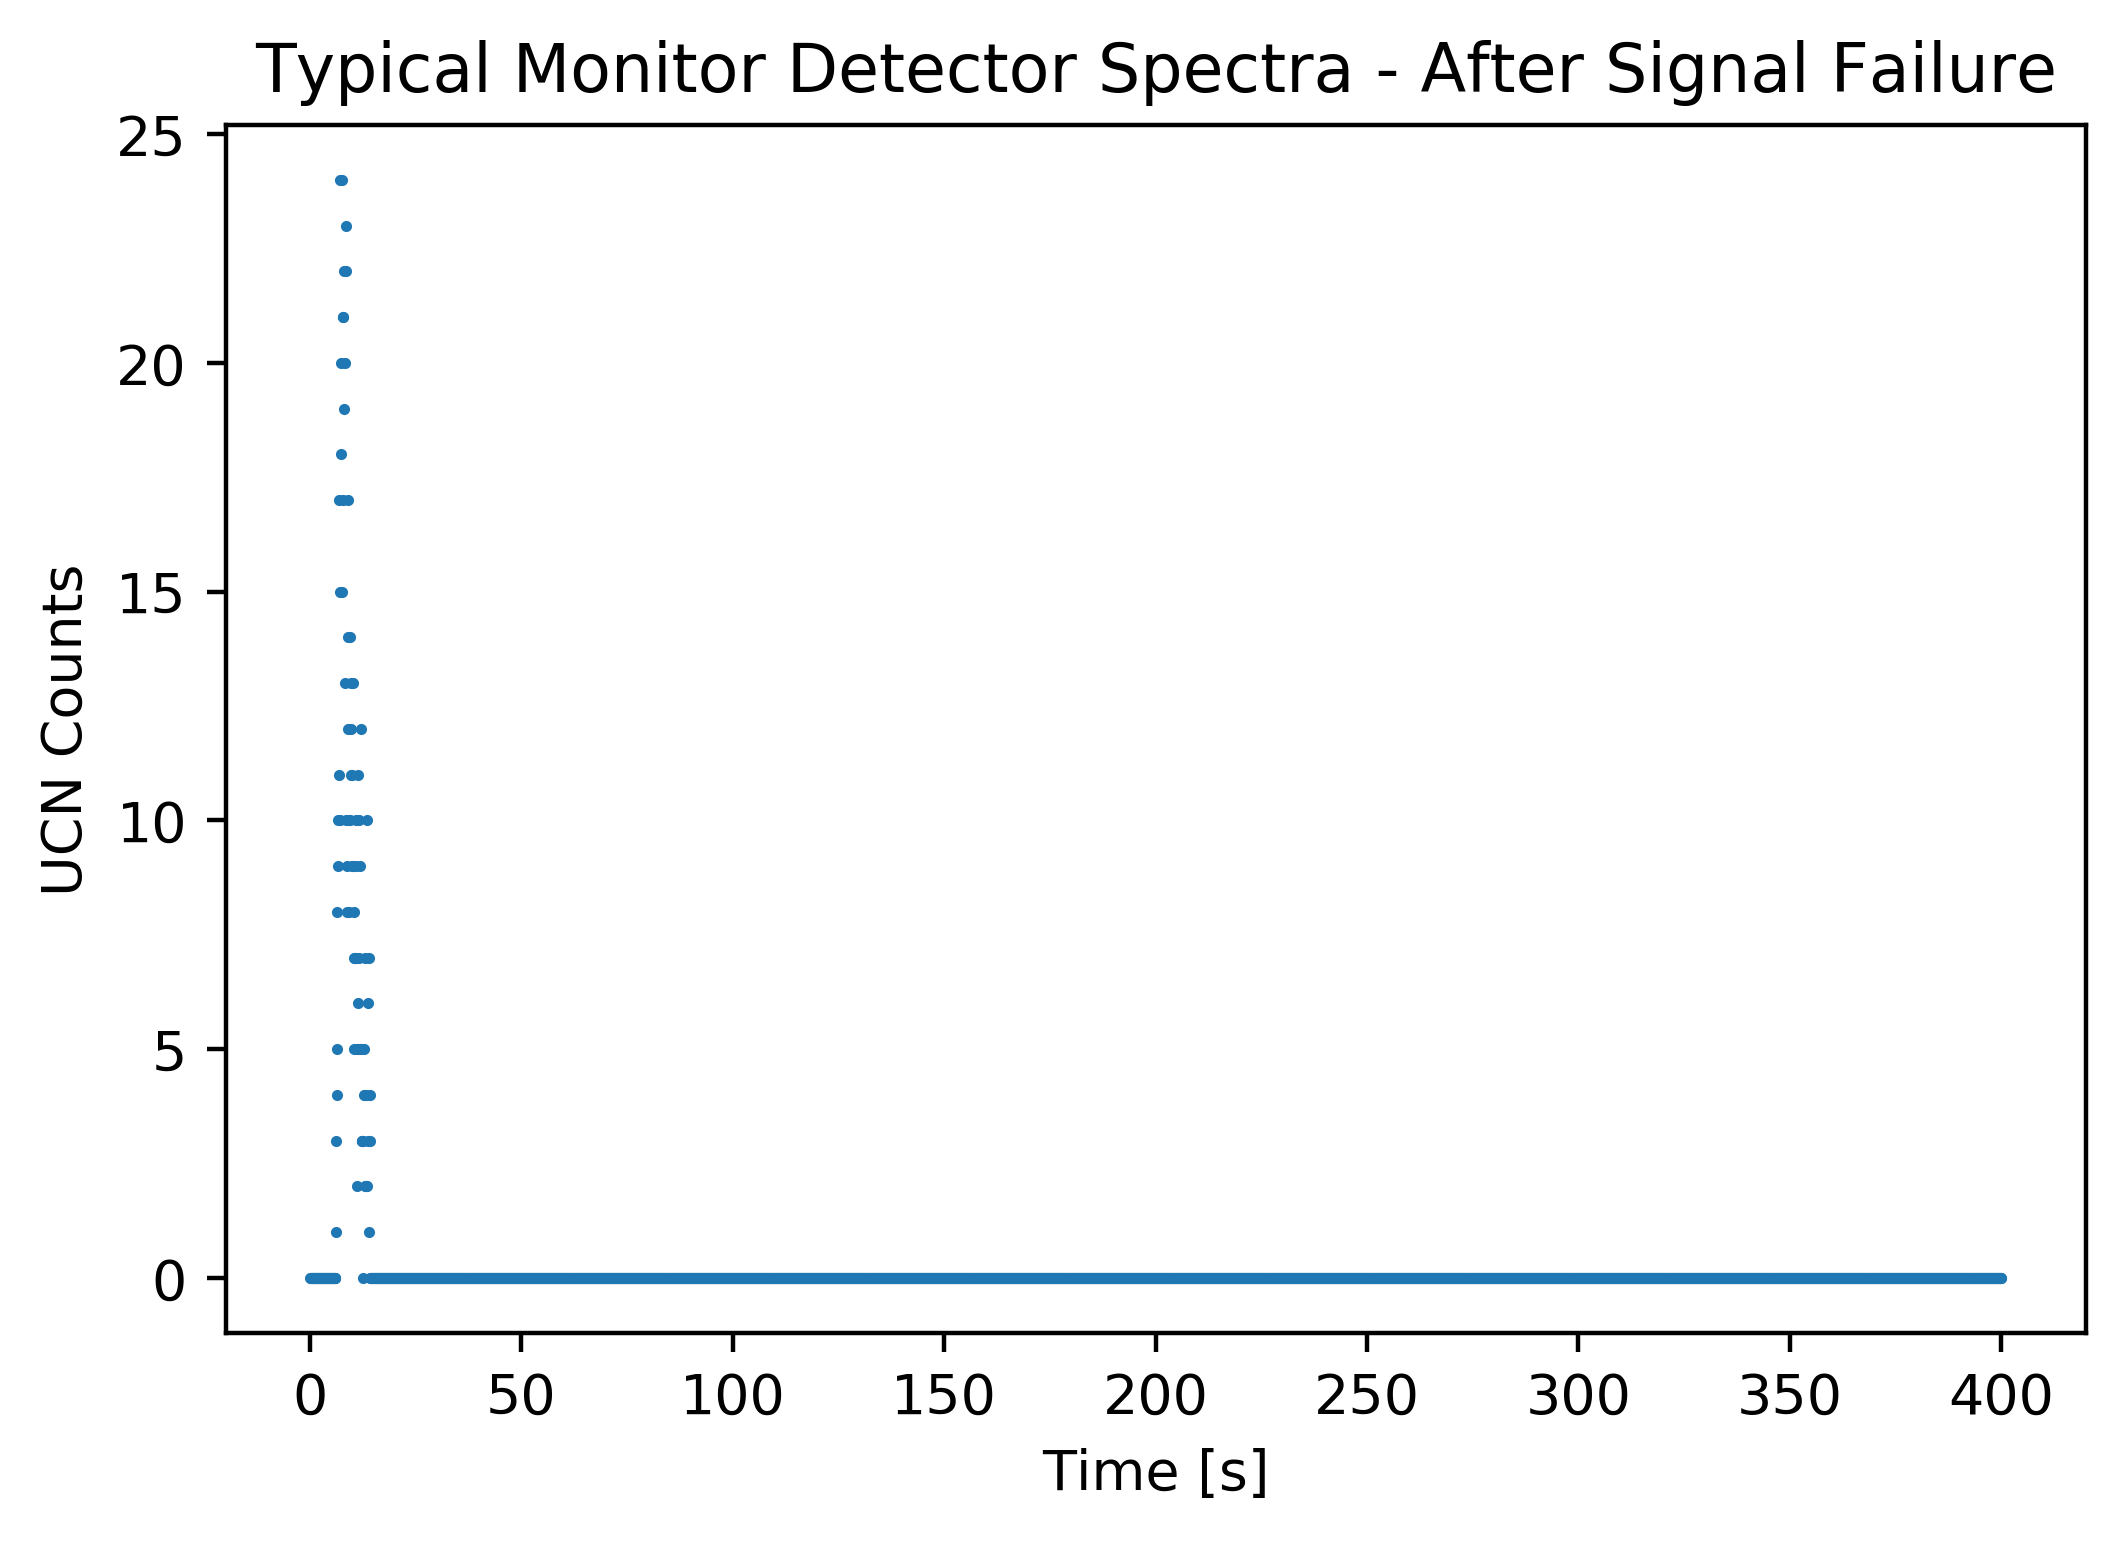

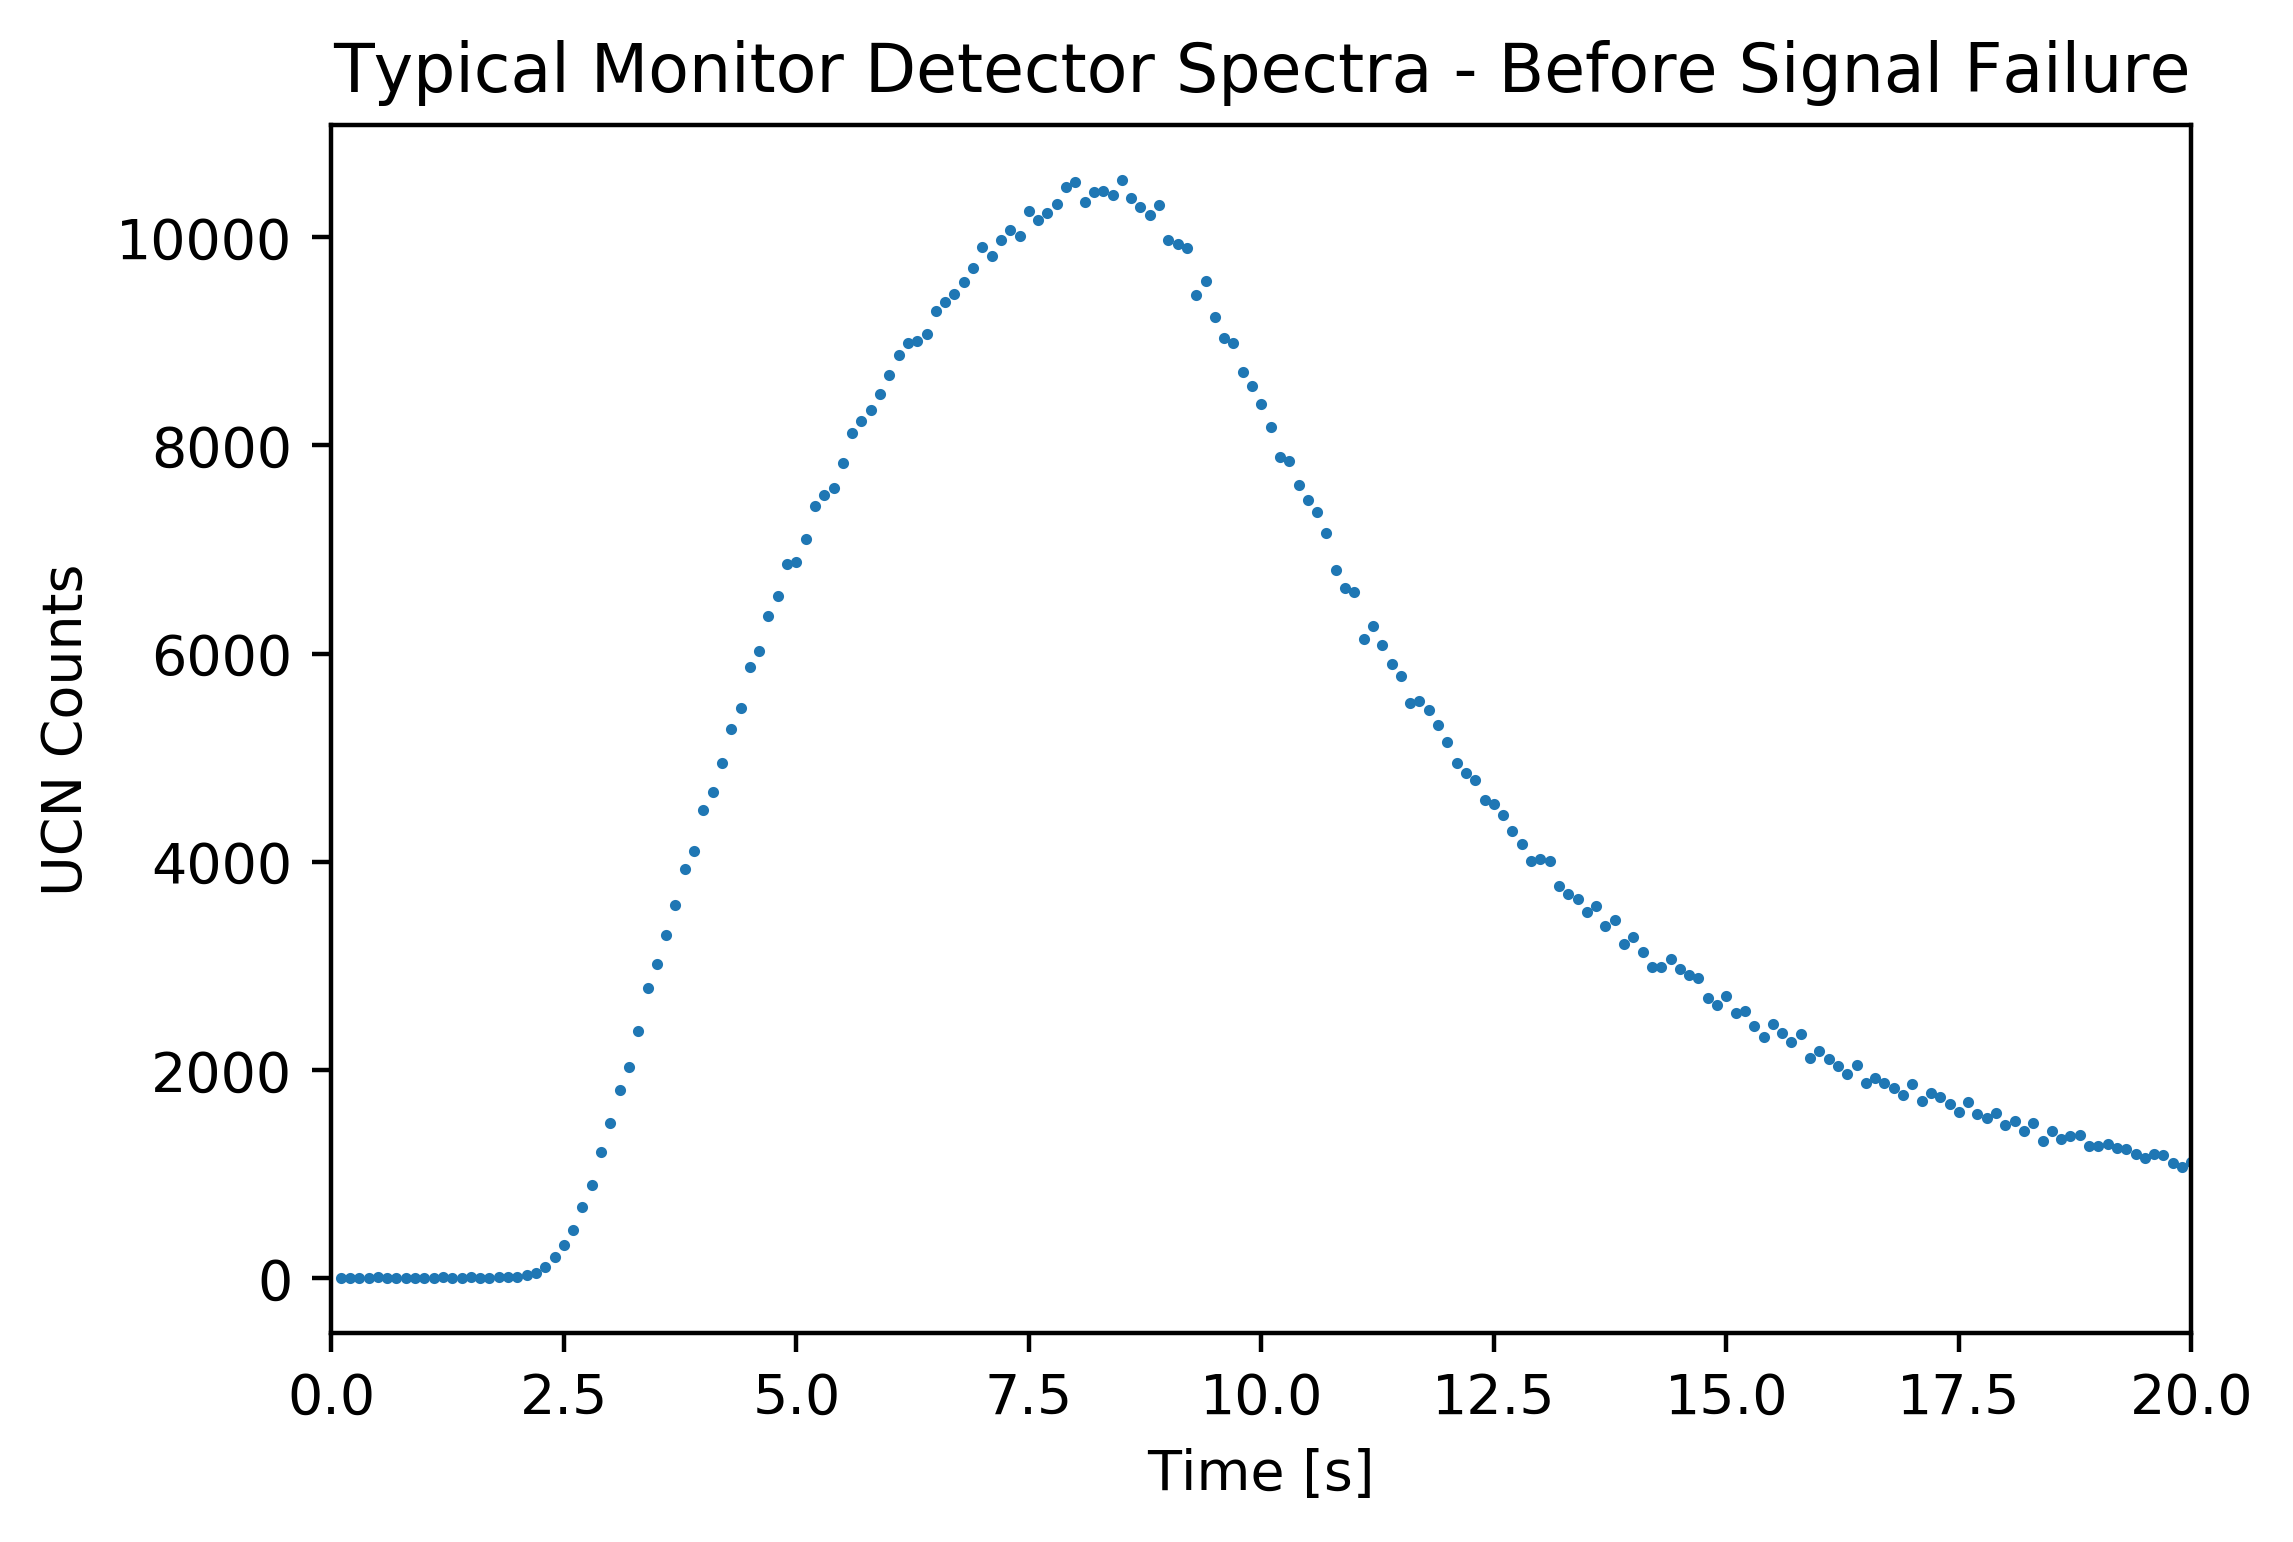

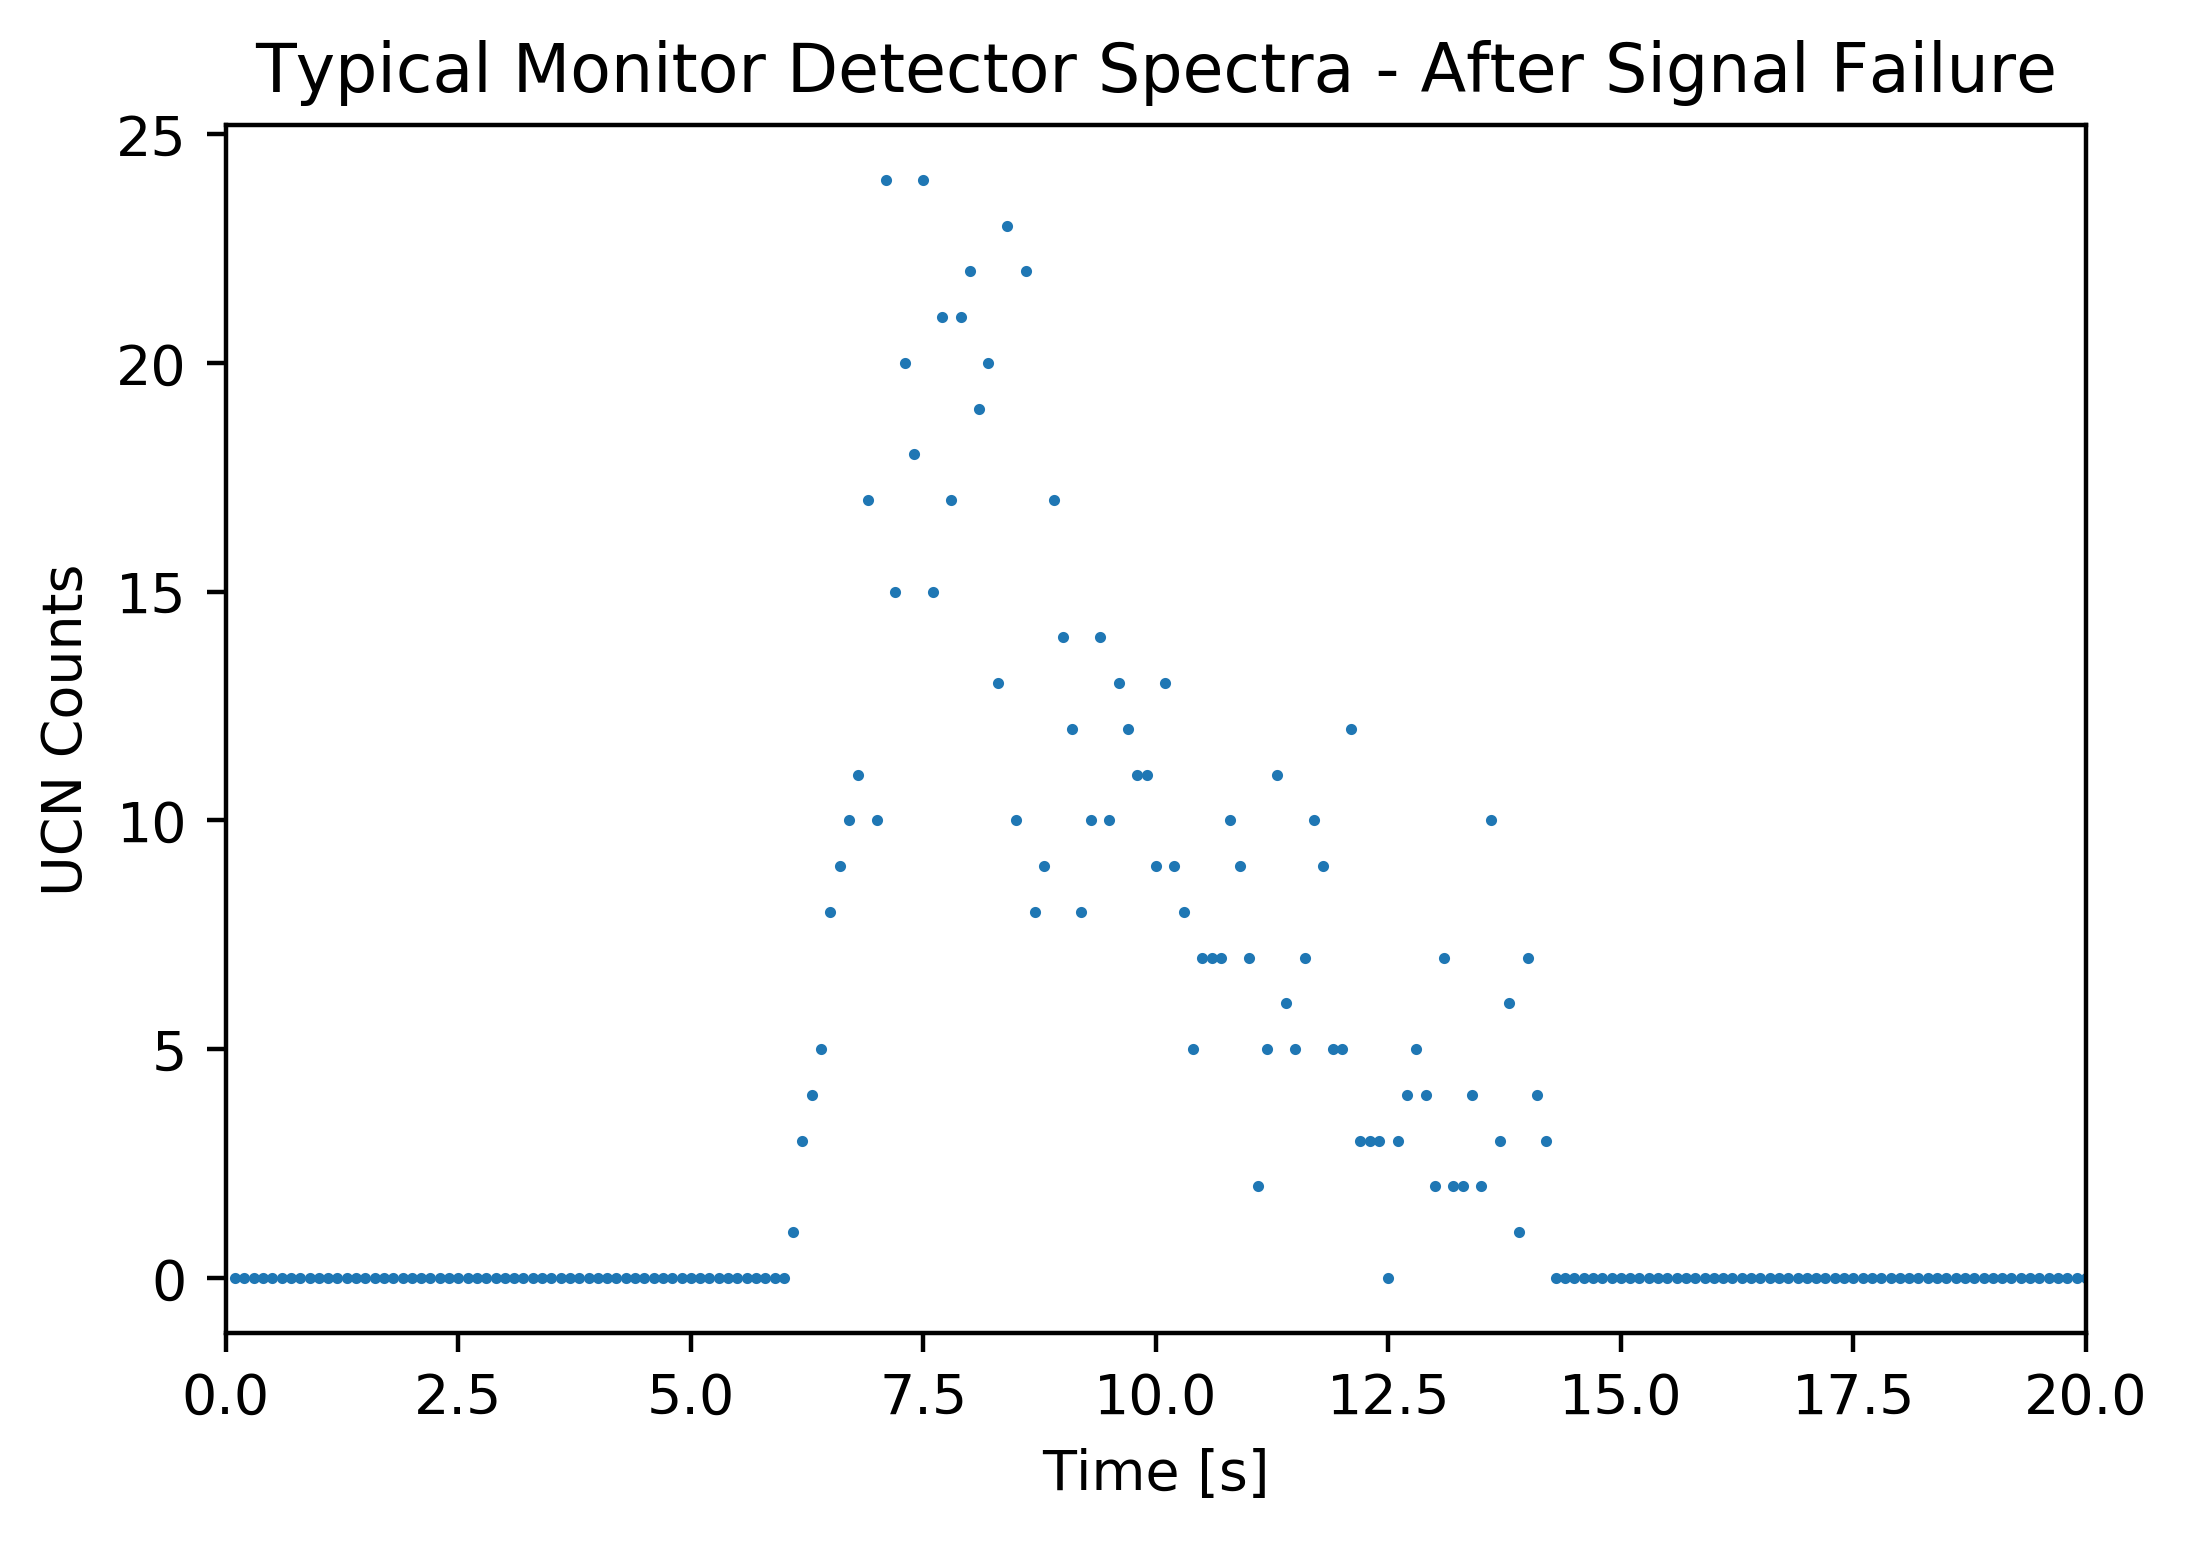

In [18]:
data = np.loadtxt("../data_monitor/12/T081217_0076.tof", usecols = (0,1));
plt.scatter(data[:,0] * 0.1, data[:,1], s=1);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Typical Monitor Detector Spectra - Before Signal Failure')
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T091217_0198.tof", usecols = (0,1));
plt.scatter(data[:,0] * 0.1, data[:,1], s=1);
plt.xlabel('Time [s]');
plt.ylabel('UCN Counts');
plt.title('Typical Monitor Detector Spectra - After Signal Failure')
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T081217_0076.tof", usecols = (0,1));
plt.scatter(data[:,0] * 0.1, data[:,1], s=1);
plt.xlabel('Time [s]');
plt.xlim([0,20]);
plt.title('Typical Monitor Detector Spectra - Before Signal Failure')
plt.ylabel('UCN Counts');
plt.show()

plt.clf()
data = np.loadtxt("../data_monitor/12/T091217_0198.tof", usecols = (0,1));
plt.scatter(data[:,0] * 0.1, data[:,1], s=1);
plt.xlabel('Time [s]');
plt.xlim([0,20]);
plt.title('Typical Monitor Detector Spectra - After Signal Failure')
plt.ylabel('UCN Counts');

Bernhard's interpretation:

>The UCN Detector is started with actually a signal about 8 s before the proton beam kick<br/>
And it needs a second signal to be stopped and restart the file.<br/>
Every other time one of these two signals fails and the detector is out of sync with the<br/>
proton beam. Therefore you do not see the standard UCN delivery over<br/>
the 300 seconds period but just the UCN counts over the time of ~7 seconds<br/>
just before the proton kick, when ususally the file is restarted.<br/>
i.e. the last seconds to the right of the 'normal ' time plot.

This interpretation means that during this period we observe the background monitor detector counts during the period of time prior to irradiation. If this is true, then why do we see any counts at all? Conversely, when these two signals are in sync and working properly, the counts will decay to zero by the end of the run. Does this suggest that Edgard applied some background correction to the Monitor Detector data also? 

# Proton Beam Current Stability and Background Corrections

Below is the plot from Edgard's February slides of the proton beam current stability. In these slides Edgard also claims that background correction has been performed on the data. We've requested detail on these corrections, and the raw data to work with and hopefully reproduce the results. 

![](../misc/beam_current_edgard.png)
![](jonahberean/psi_transmission/misc/beam_current_edgard.png)

# Error Propagation and the Source Performance Normalization

# Transmission

The analysis of the source performance allowed for a normalization of every run's counts to effectively remove the linear source degradation effect. If we look at just the runs in the 'nominal' configuration (that is, the guide-less configuration), after the source performance normalization, we relatively see flat, unchanging count totals throughout the experimental campaign. This is as we would hope, indicating the degradation has been properly "normalized away".

Fit parameters:
 N_0 = 133207.5945824243 +/- 228.05867454065873,
 A: -2.231843332367589e-08 +/- 0.0009986688573663568
Fit parameters:
 N_0 = 69776.486943231 +/- 186.24178654083605,
 A: 5.3179459058583234e-08 +/- 0.0008405562805048948
Fit parameters:
 N_0 = 5466.390409581145 +/- 34.66447715298638,
 A: 1.8705815563180295e-08 +/- 0.00015150376070479938
Fit parameters:
 N_0 = 4195635.767372111 +/- 3635.5394922520704,
 A: -5.0490943195313776e-06 +/- 0.01544452169990635


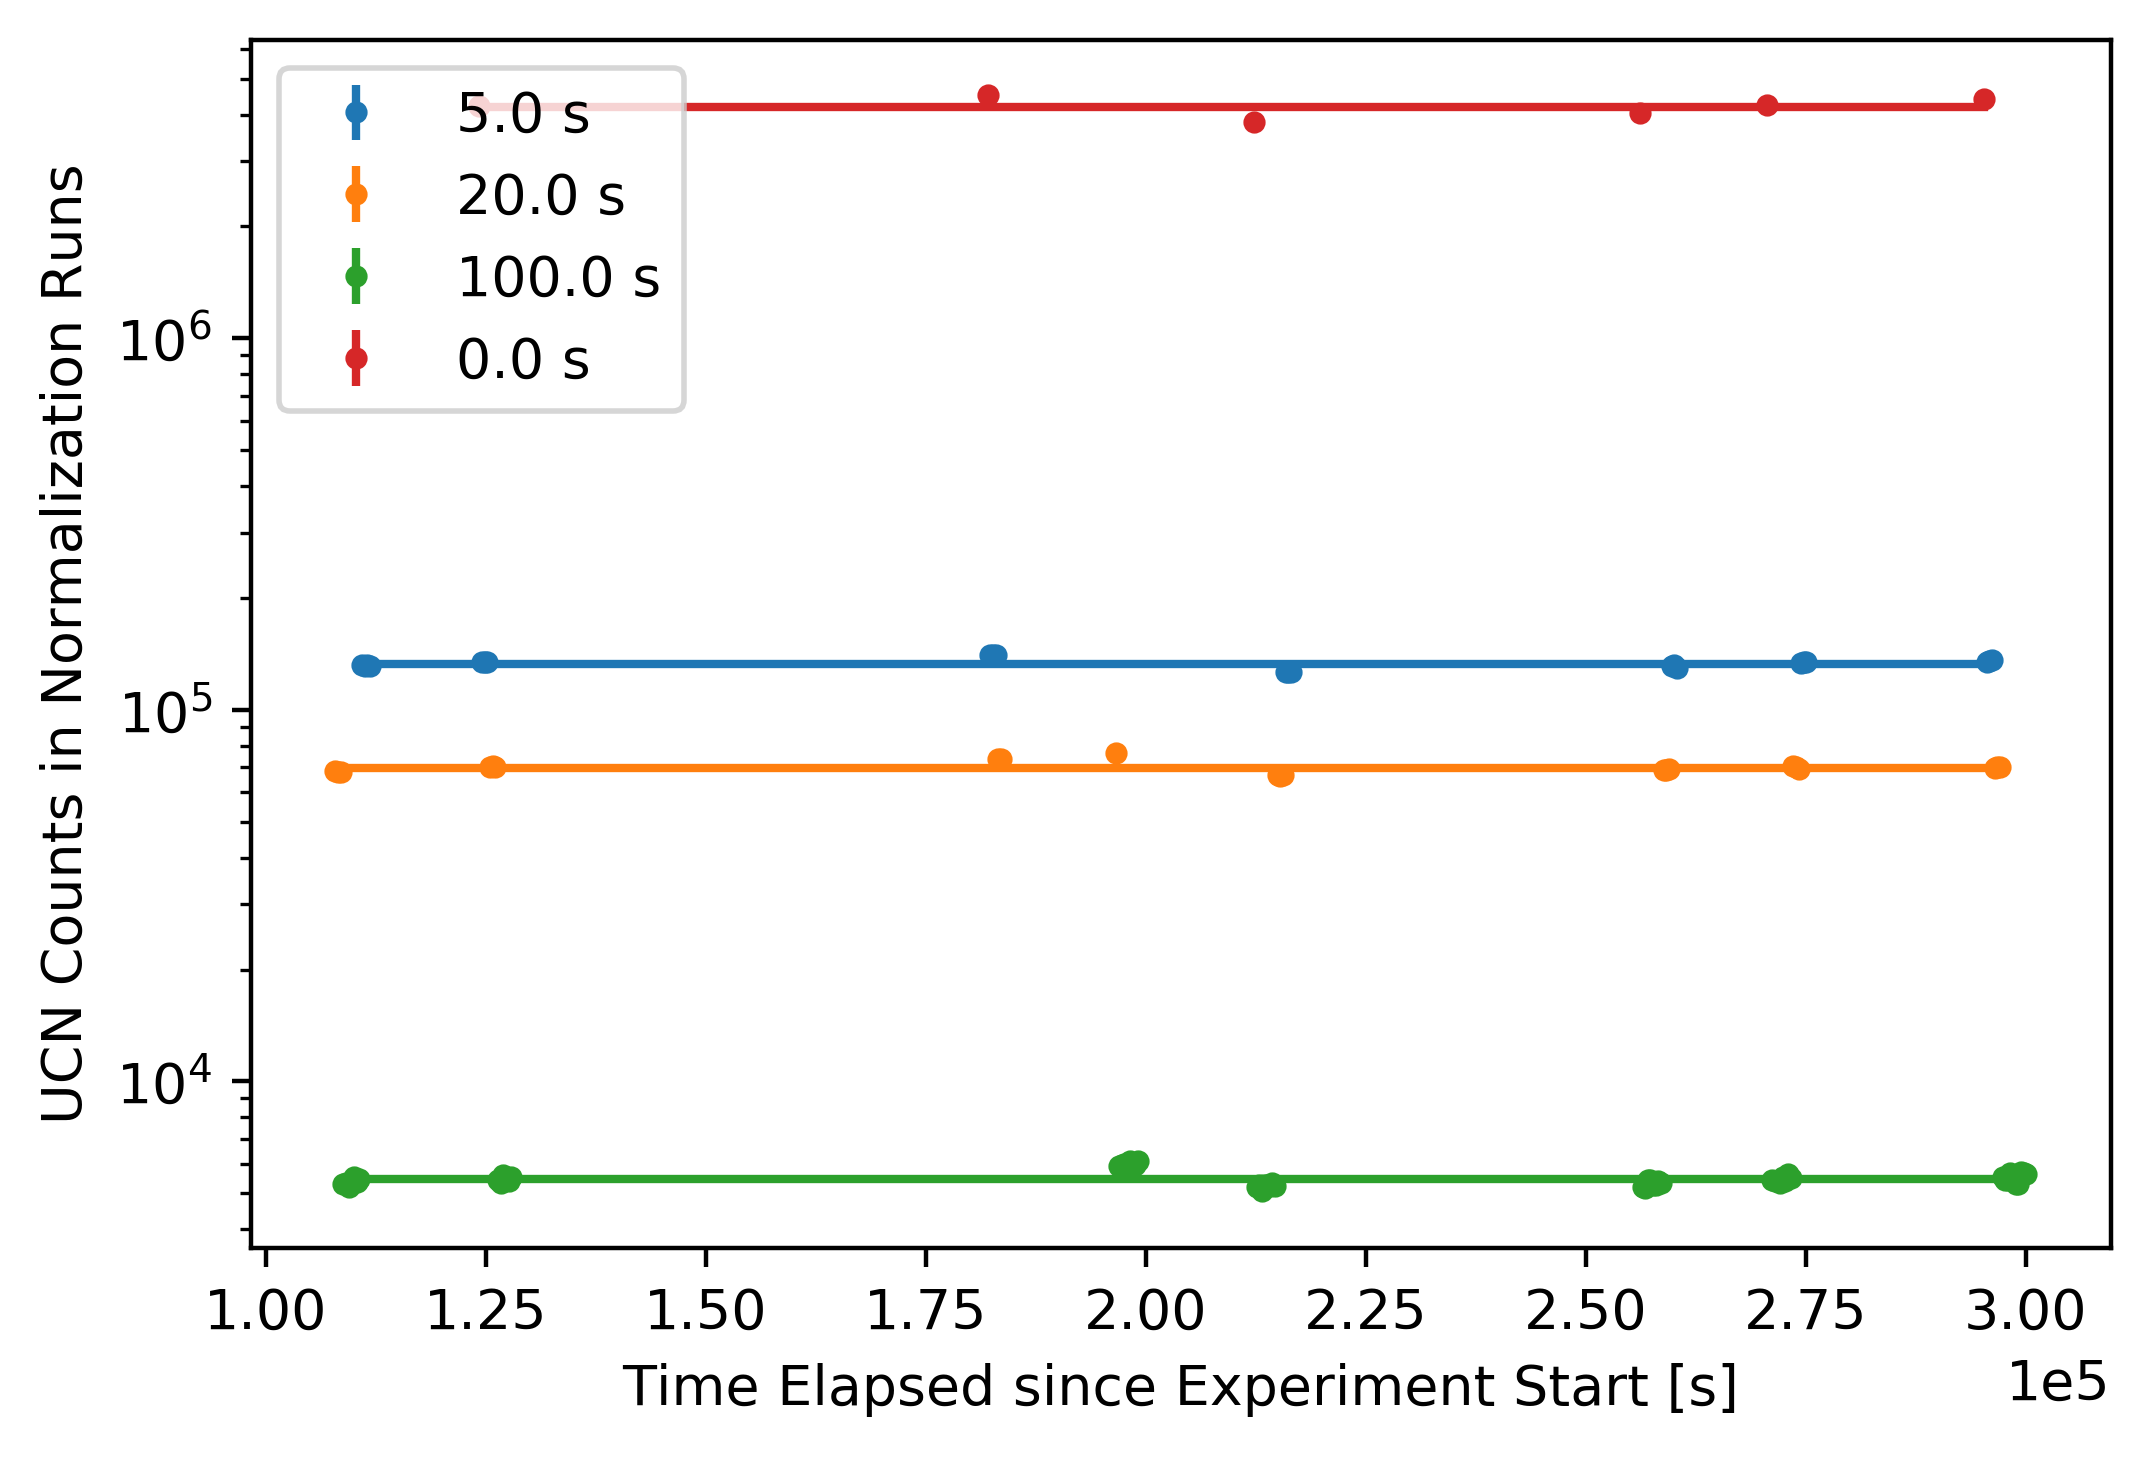

In [6]:
ax = plt.gca()
for arr in norm_data_list:
    color = next(ax._get_lines.prop_cycler)['color']
    plt.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', label = '{} s'.format(arr[0,1]), color = color)
    popt, pcov = curve_fit(source_fit, arr[:,0], arr[:,2], p0=[77600, -9], sigma = arr[:,3], absolute_sigma = True)
    plt.plot(arr[:,0], source_fit(arr[:,0], *popt), color = color);

    # printing the fit parameters and their errors:
    fit_parameters = np.zeros(np.shape(pcov))
    for i in range(0, np.size(popt)):
        fit_parameters[i,0] = popt[i]
        fit_parameters[i,1] = np.sqrt(np.diag(pcov))[i]
    print("Fit parameters:\n N_0 = {} +/- {},\n A: {} +/- {}".format(
            fit_parameters[0,0],
            fit_parameters[0,1],
            fit_parameters[1,0],
            fit_parameters[1,1]))
    
plt.legend()
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel('Time Elapsed since Experiment Start [s]')
plt.ylabel('UCN Counts in Normalization Runs');
plt.yscale('log')

With this correction in place, we can then treat all the runs which used the same pre-storage time as being equivalent repetitions of the same experiment. This will yield four results, one for each pre-storage time, and these will be used in the transmission calculation:

$$\large{T = \frac{\text{counts with guide}}{\text{nominal counts}}}$$

However, we might be concerned about the quality of the normalization, and the fact that the systematic effects within the source are not being captured well by the simple linear model. In this case, a transmission measurement using the nominal configuration runs that are closest, in time, to the guided runs being examined could be used, instead of this full experiment average. This can be revisited (!!!).

There are five guides to measure:

![](../misc/guides_edgard.png)
![](jonahberean/psi_transmission/misc/guides_edgard.png)

In [43]:
def transmission(guide_data_list, nominal_data_list = nominal_data_list):
    
    # initialize an array to hold the transmission results for each run type
    transmission_results = np.zeros((4,3))

    for i in range(0, 4):
        
        # the storage time is grabbed first
        transmission_results[i,0] = guide_data_list[i][0,1]
        
        # the average of all the relevant runs is calculated, then the ratio between
        # the nominal and the guide results gives the transmission
        guide_average = np.average(guide_data_list[i][:,2])
        nominal_average = np.average(nominal_data_list[i][:,2])
        transmission_results[i,1] = guide_average / nominal_average
        
        # compute fractional uncertainty for each, here we are averaging data so 
        # the standard error in the mean is computed
        guide_error      = np.std(guide_data_list[i][:,2]) / np.sqrt(np.shape(guide_data_list[i][:,2])[0])
        guide_frac_error = guide_error / guide_average
        nominal_error    = np.std(nominal_data_list[i][:,2]) / np.sqrt(np.shape(nominal_data_list[i][:,2])[0])
        nominal_frac_error   = nominal_error / nominal_average
        
        # error on transmission is propagated by summing the fractional uncertainties in 
        # quadrature
        transmission_frac_error = np.sqrt(guide_frac_error**2 + nominal_frac_error**2)
        transmission_results[i,2] = transmission_results[i,1] * transmission_frac_error   
        
    plt.errorbar(transmission_results[:,0], transmission_results[:,1], yerr = transmission_results[:,2], fmt = '.');
    plt.ylabel('Transmission Ratio');
    plt.xlabel('Storage time [s]');
    return transmission_results

## Results

Guide                        | Storage Time  | Transmission | Uncertainty |
---                          |     ---       |              |             |
      UGD01                  |  direct       |              |             |
      UGD01                  |  direct       |              |             |      
      UGD03                  |  direct       |              |             |  
      EPSUS                  |  direct       |              |             | 
      JPSUS                  |  direct       |              |             |  
      JPTi                   |  direct       |              |             | 

## UGD01

array([[5.00000000e+00, 9.32260106e-01, 6.04524085e-03],
       [2.00000000e+01, 9.37167984e-01, 7.44165743e-03],
       [1.00000000e+02, 9.36262719e-01, 6.19314183e-03],
       [0.00000000e+00, 8.65785432e-01, 1.91913608e-02]])

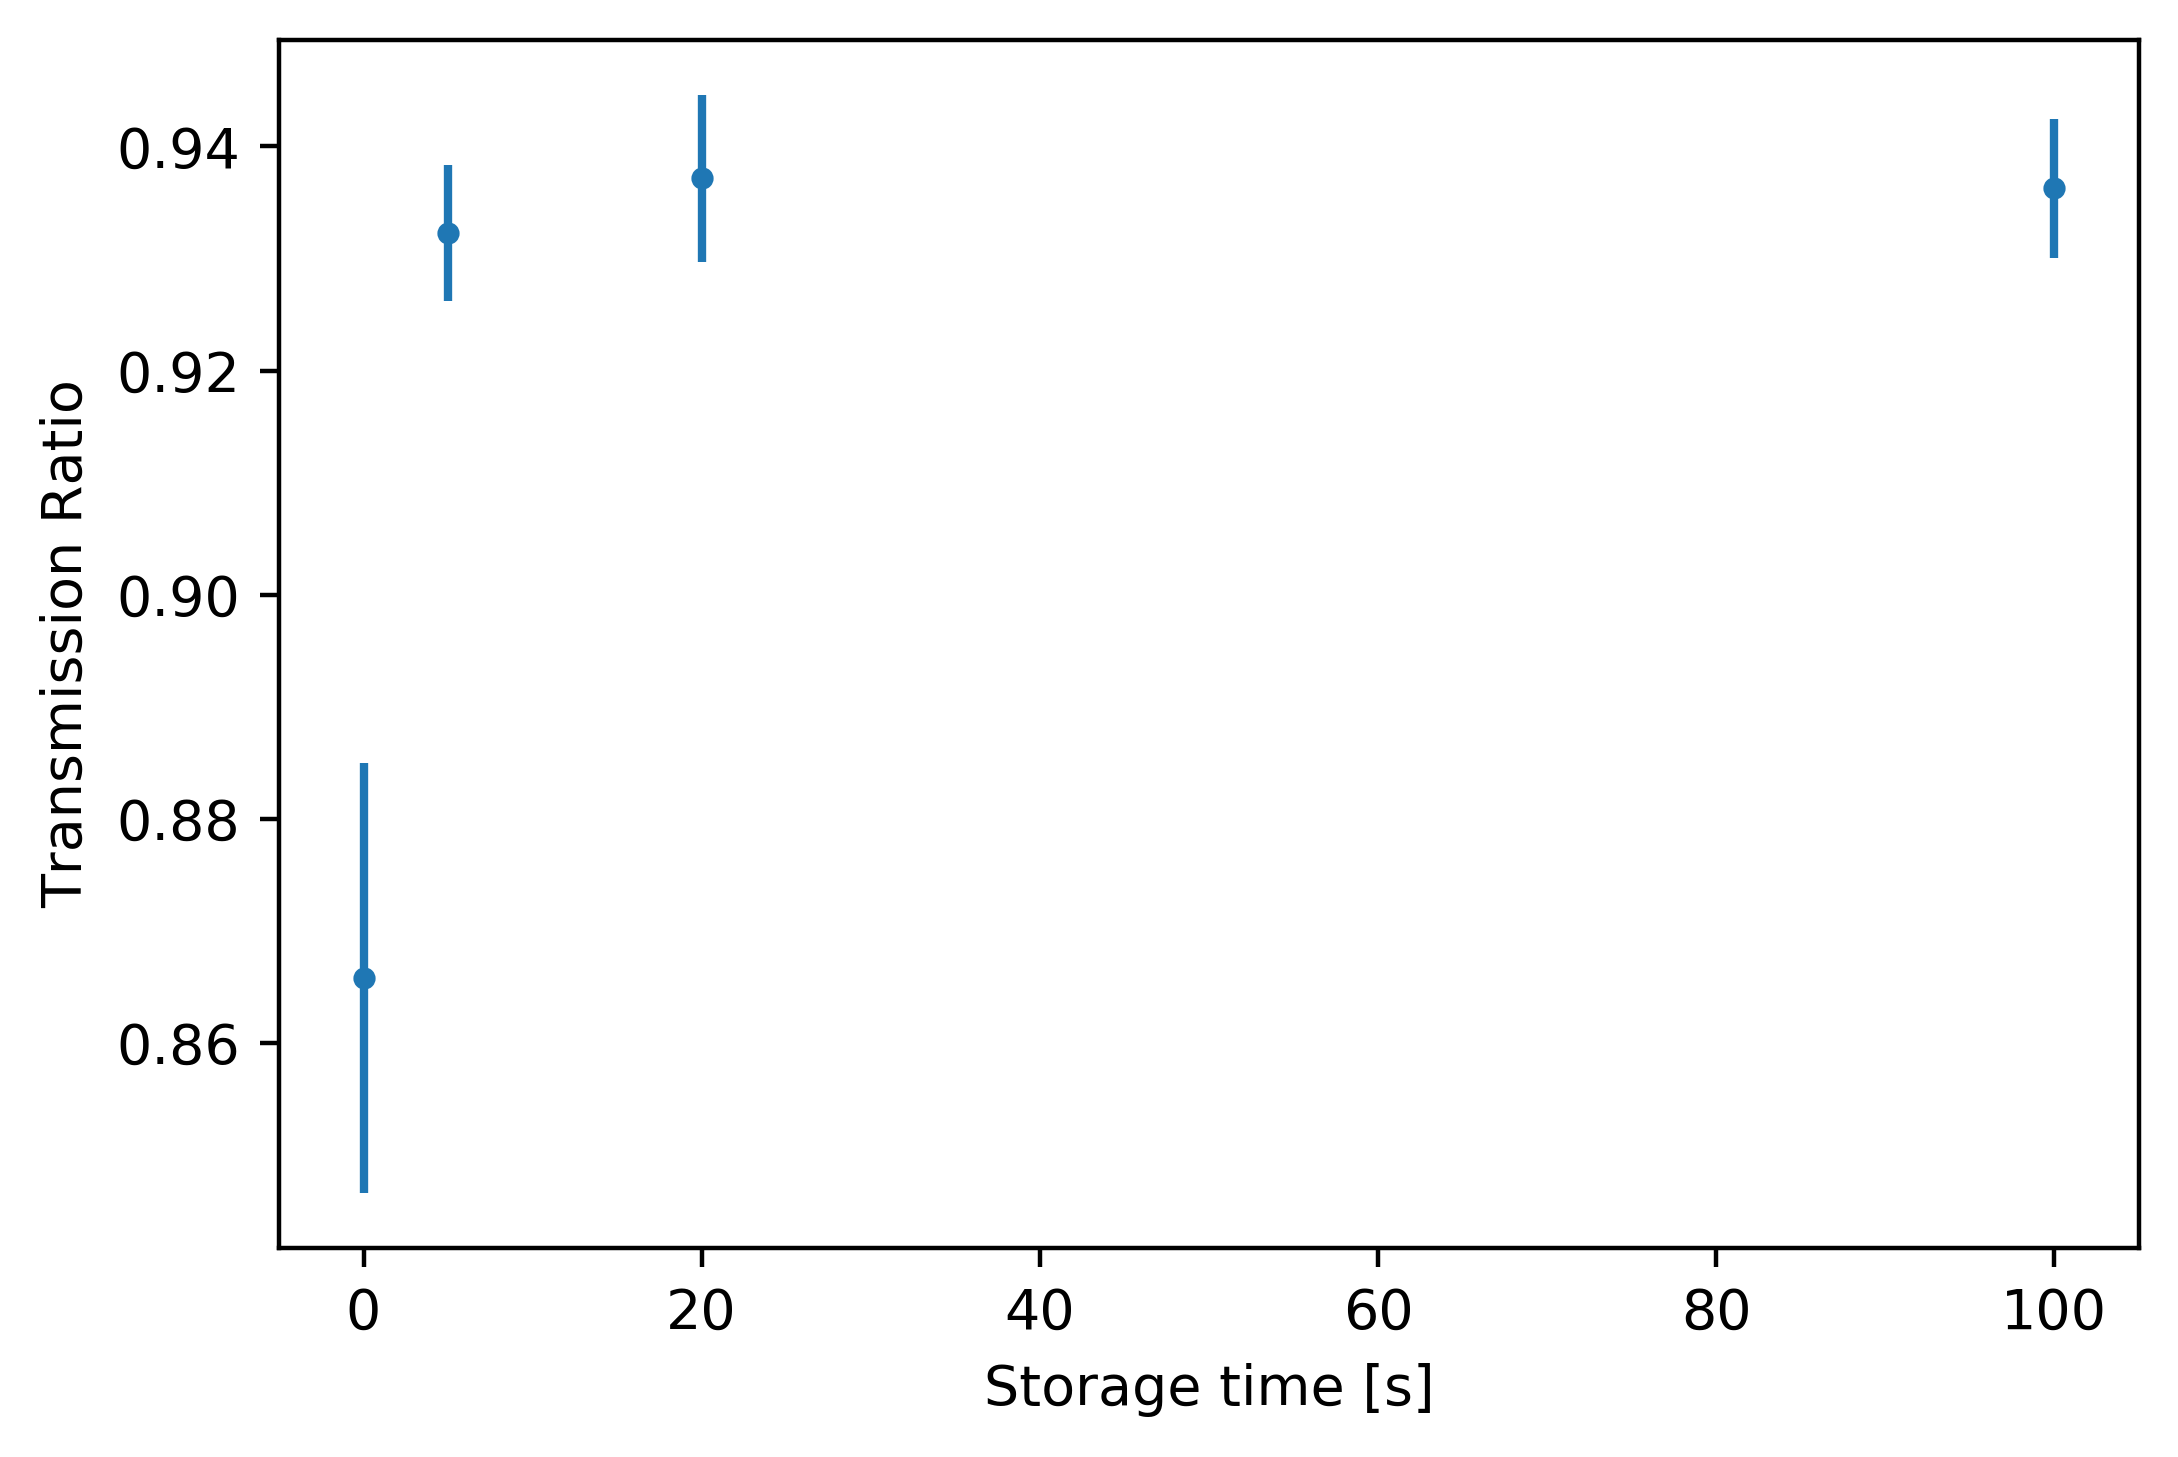

In [49]:
gd01_transmission_results = transmission(gd01_data_list)
gd01_transmission_results

## UGD03

array([[5.00000000e+00, 9.34885864e-01, 6.01540151e-03],
       [2.00000000e+01, 9.37212833e-01, 6.96427519e-03],
       [1.00000000e+02, 9.31858408e-01, 9.26821824e-03],
       [0.00000000e+00, 9.07540942e-01, 2.01169309e-02]])

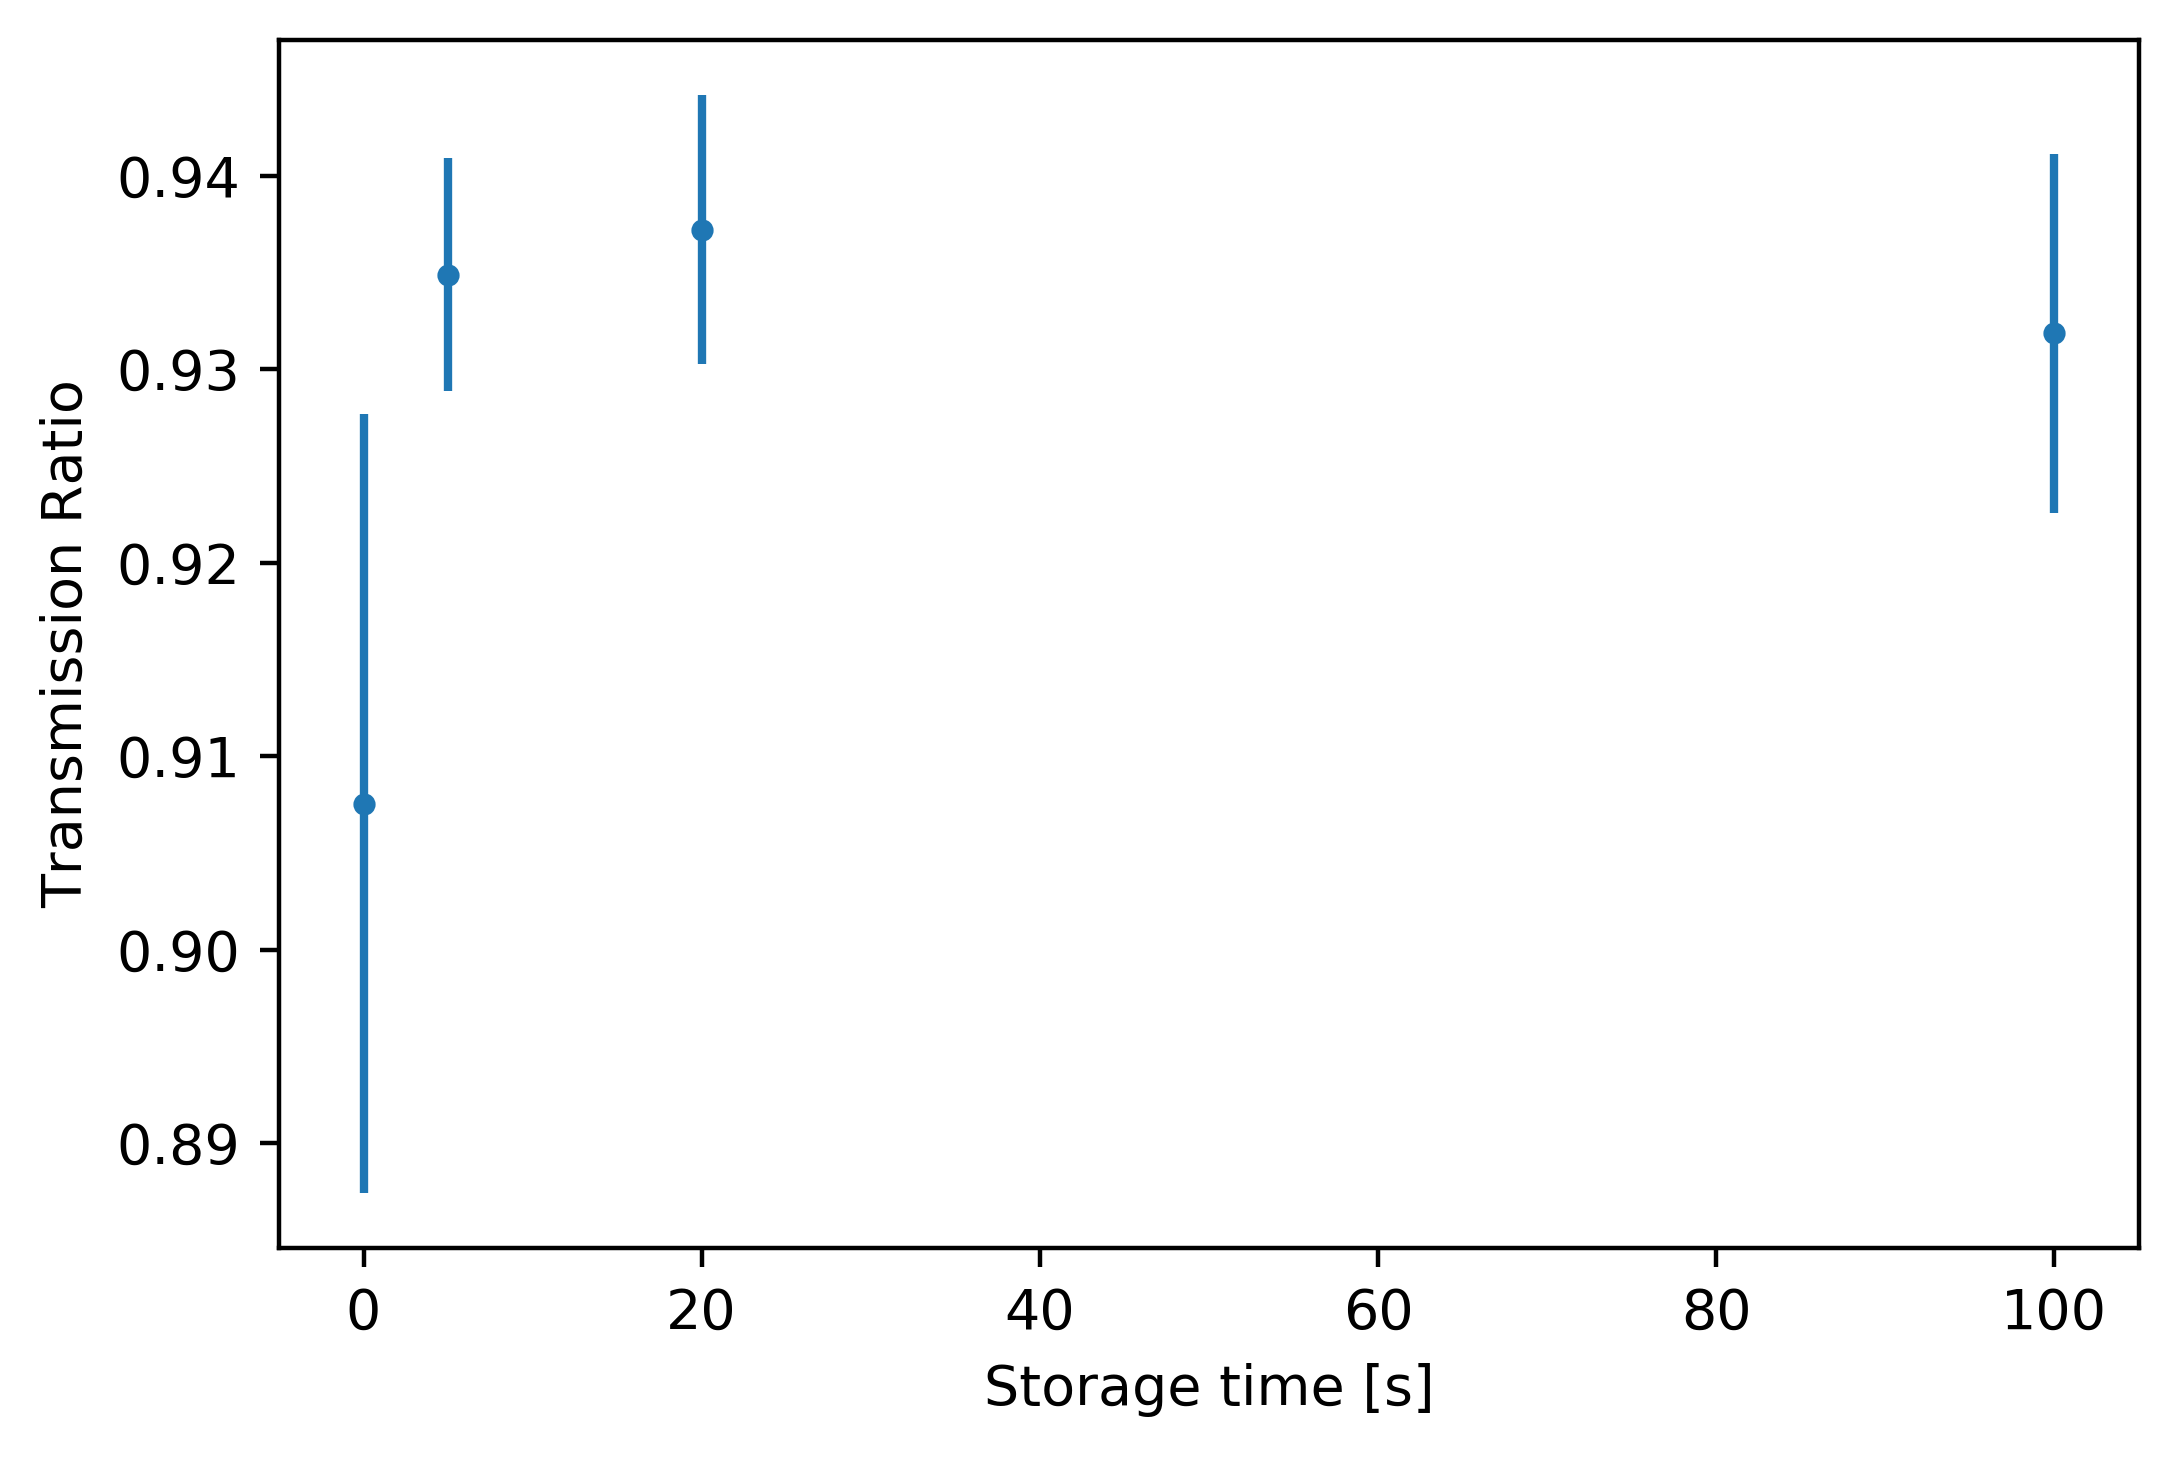

In [50]:
gd03_transmission_results = transmission(gd03_data_list)
gd03_transmission_results

## EP SUS with NiP

array([[5.00000000e+00, 9.71850157e-01, 6.03609418e-03],
       [2.00000000e+01, 9.67754935e-01, 7.14646445e-03],
       [1.00000000e+02, 9.53894037e-01, 6.91678043e-03],
       [0.00000000e+00, 9.82917158e-01, 2.24980031e-02]])

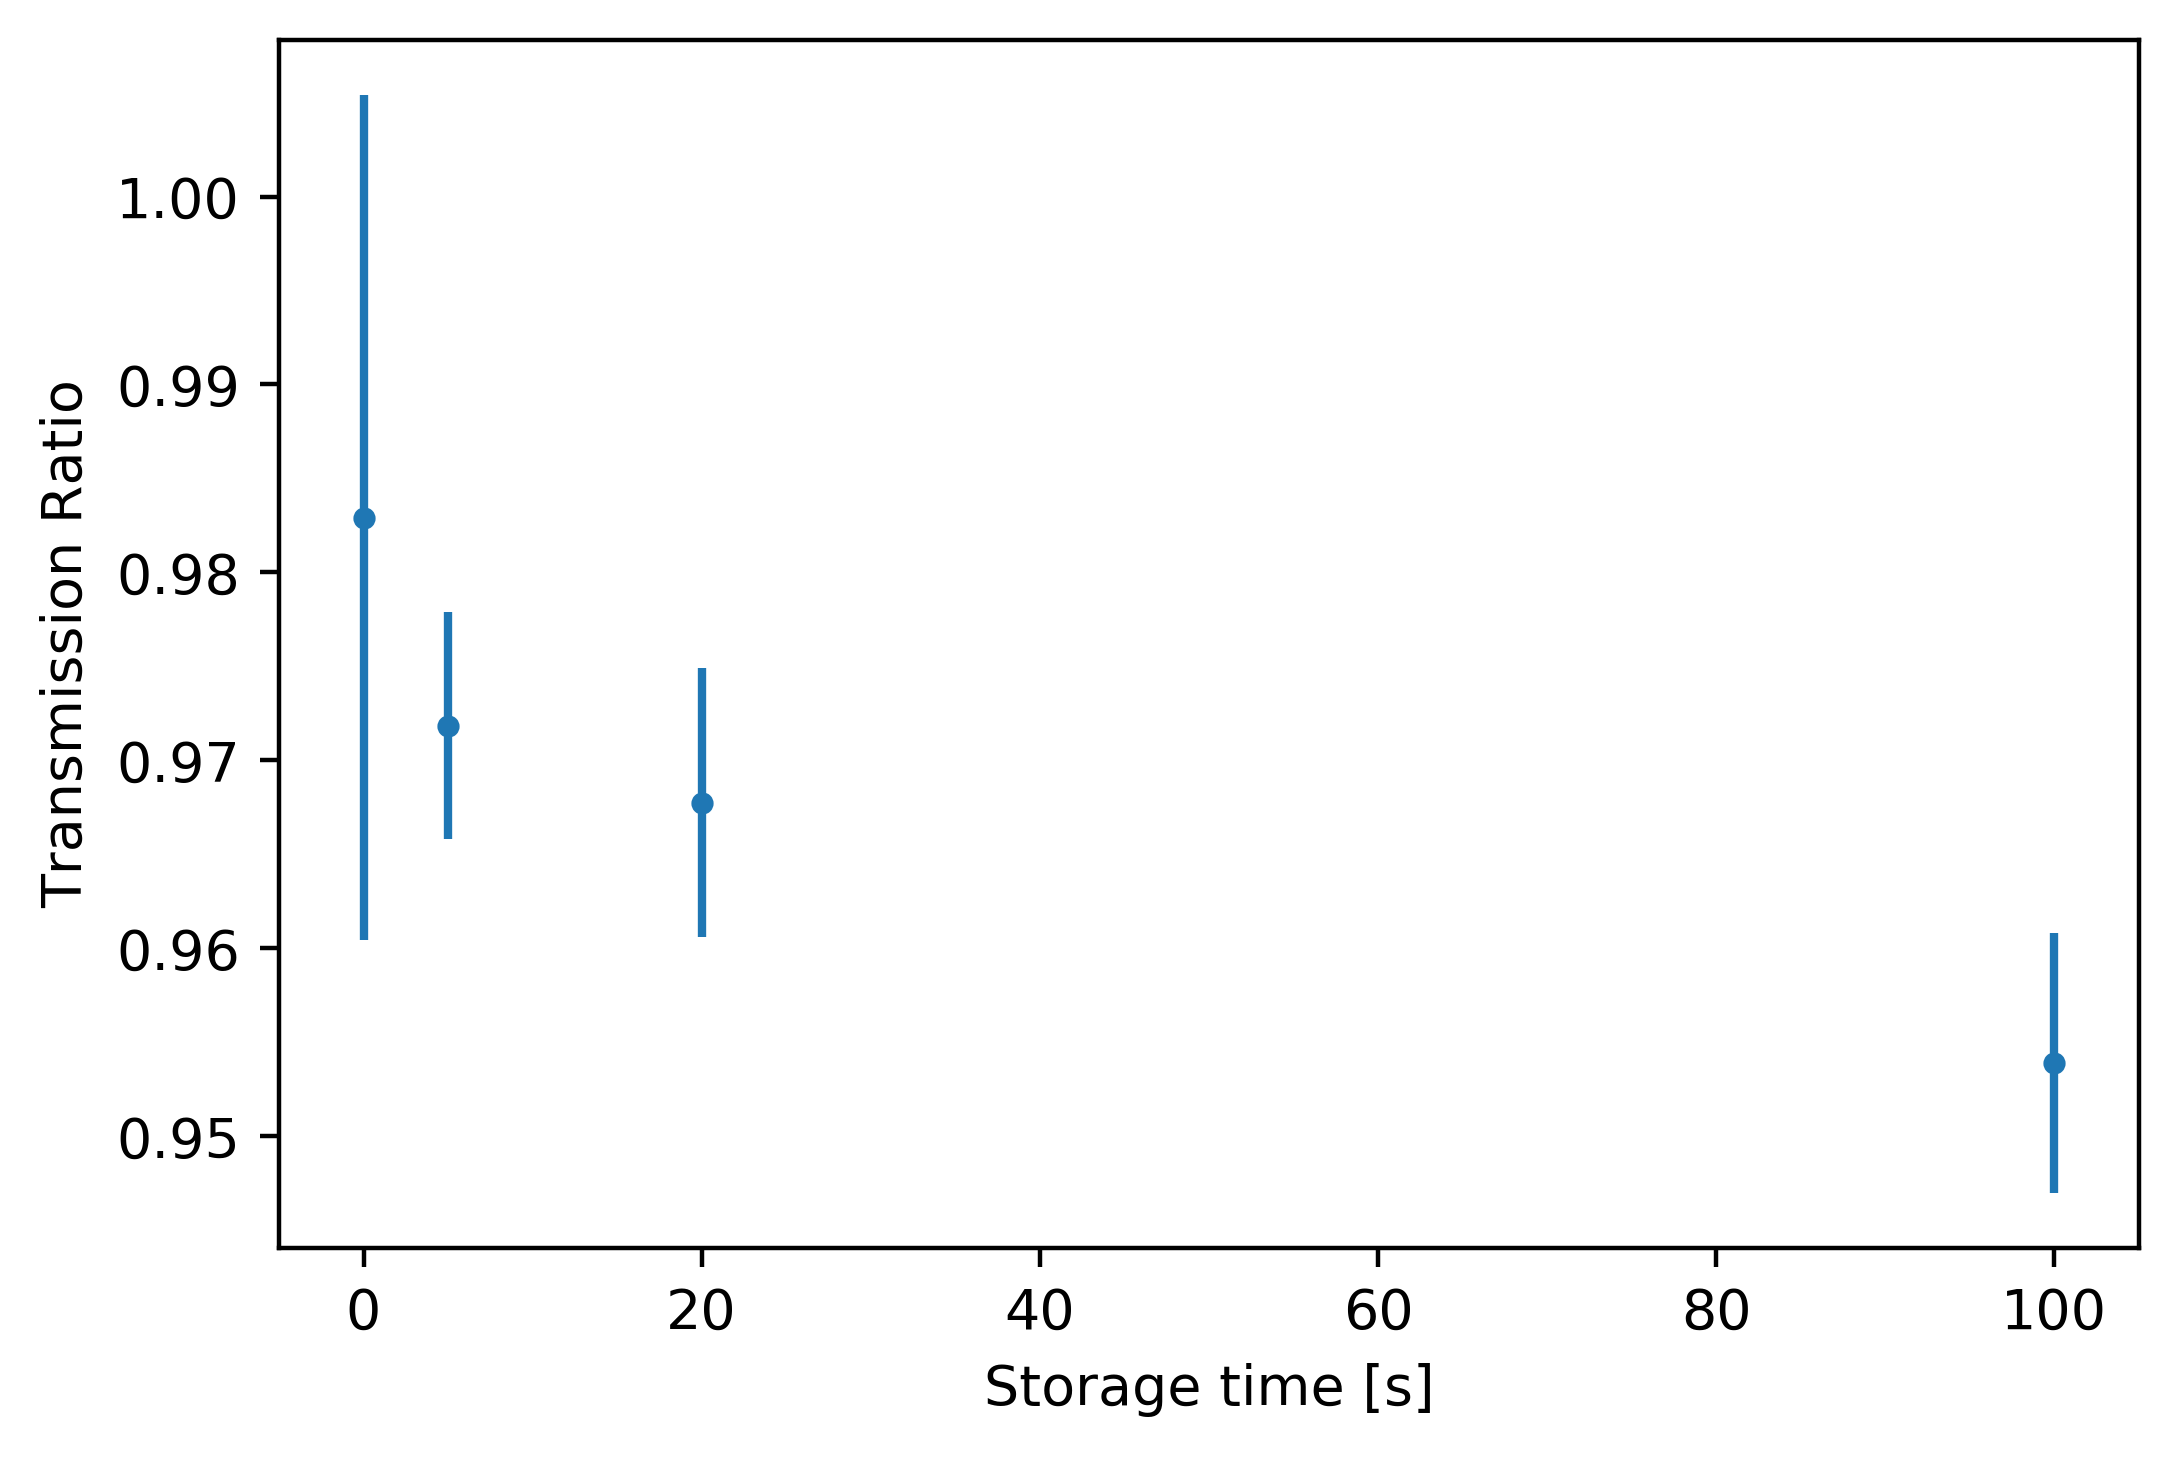

In [51]:
epsu_transmission_results = transmission(epsu_data_list)
epsu_transmission_results

## JP SUS with NiP

array([[5.00000000e+00, 7.10000305e-01, 4.73621901e-03],
       [2.00000000e+01, 7.20947177e-01, 5.61361321e-03],
       [1.00000000e+02, 7.04639127e-01, 7.08943382e-03],
       [0.00000000e+00, 6.16956572e-01, 1.36757166e-02]])

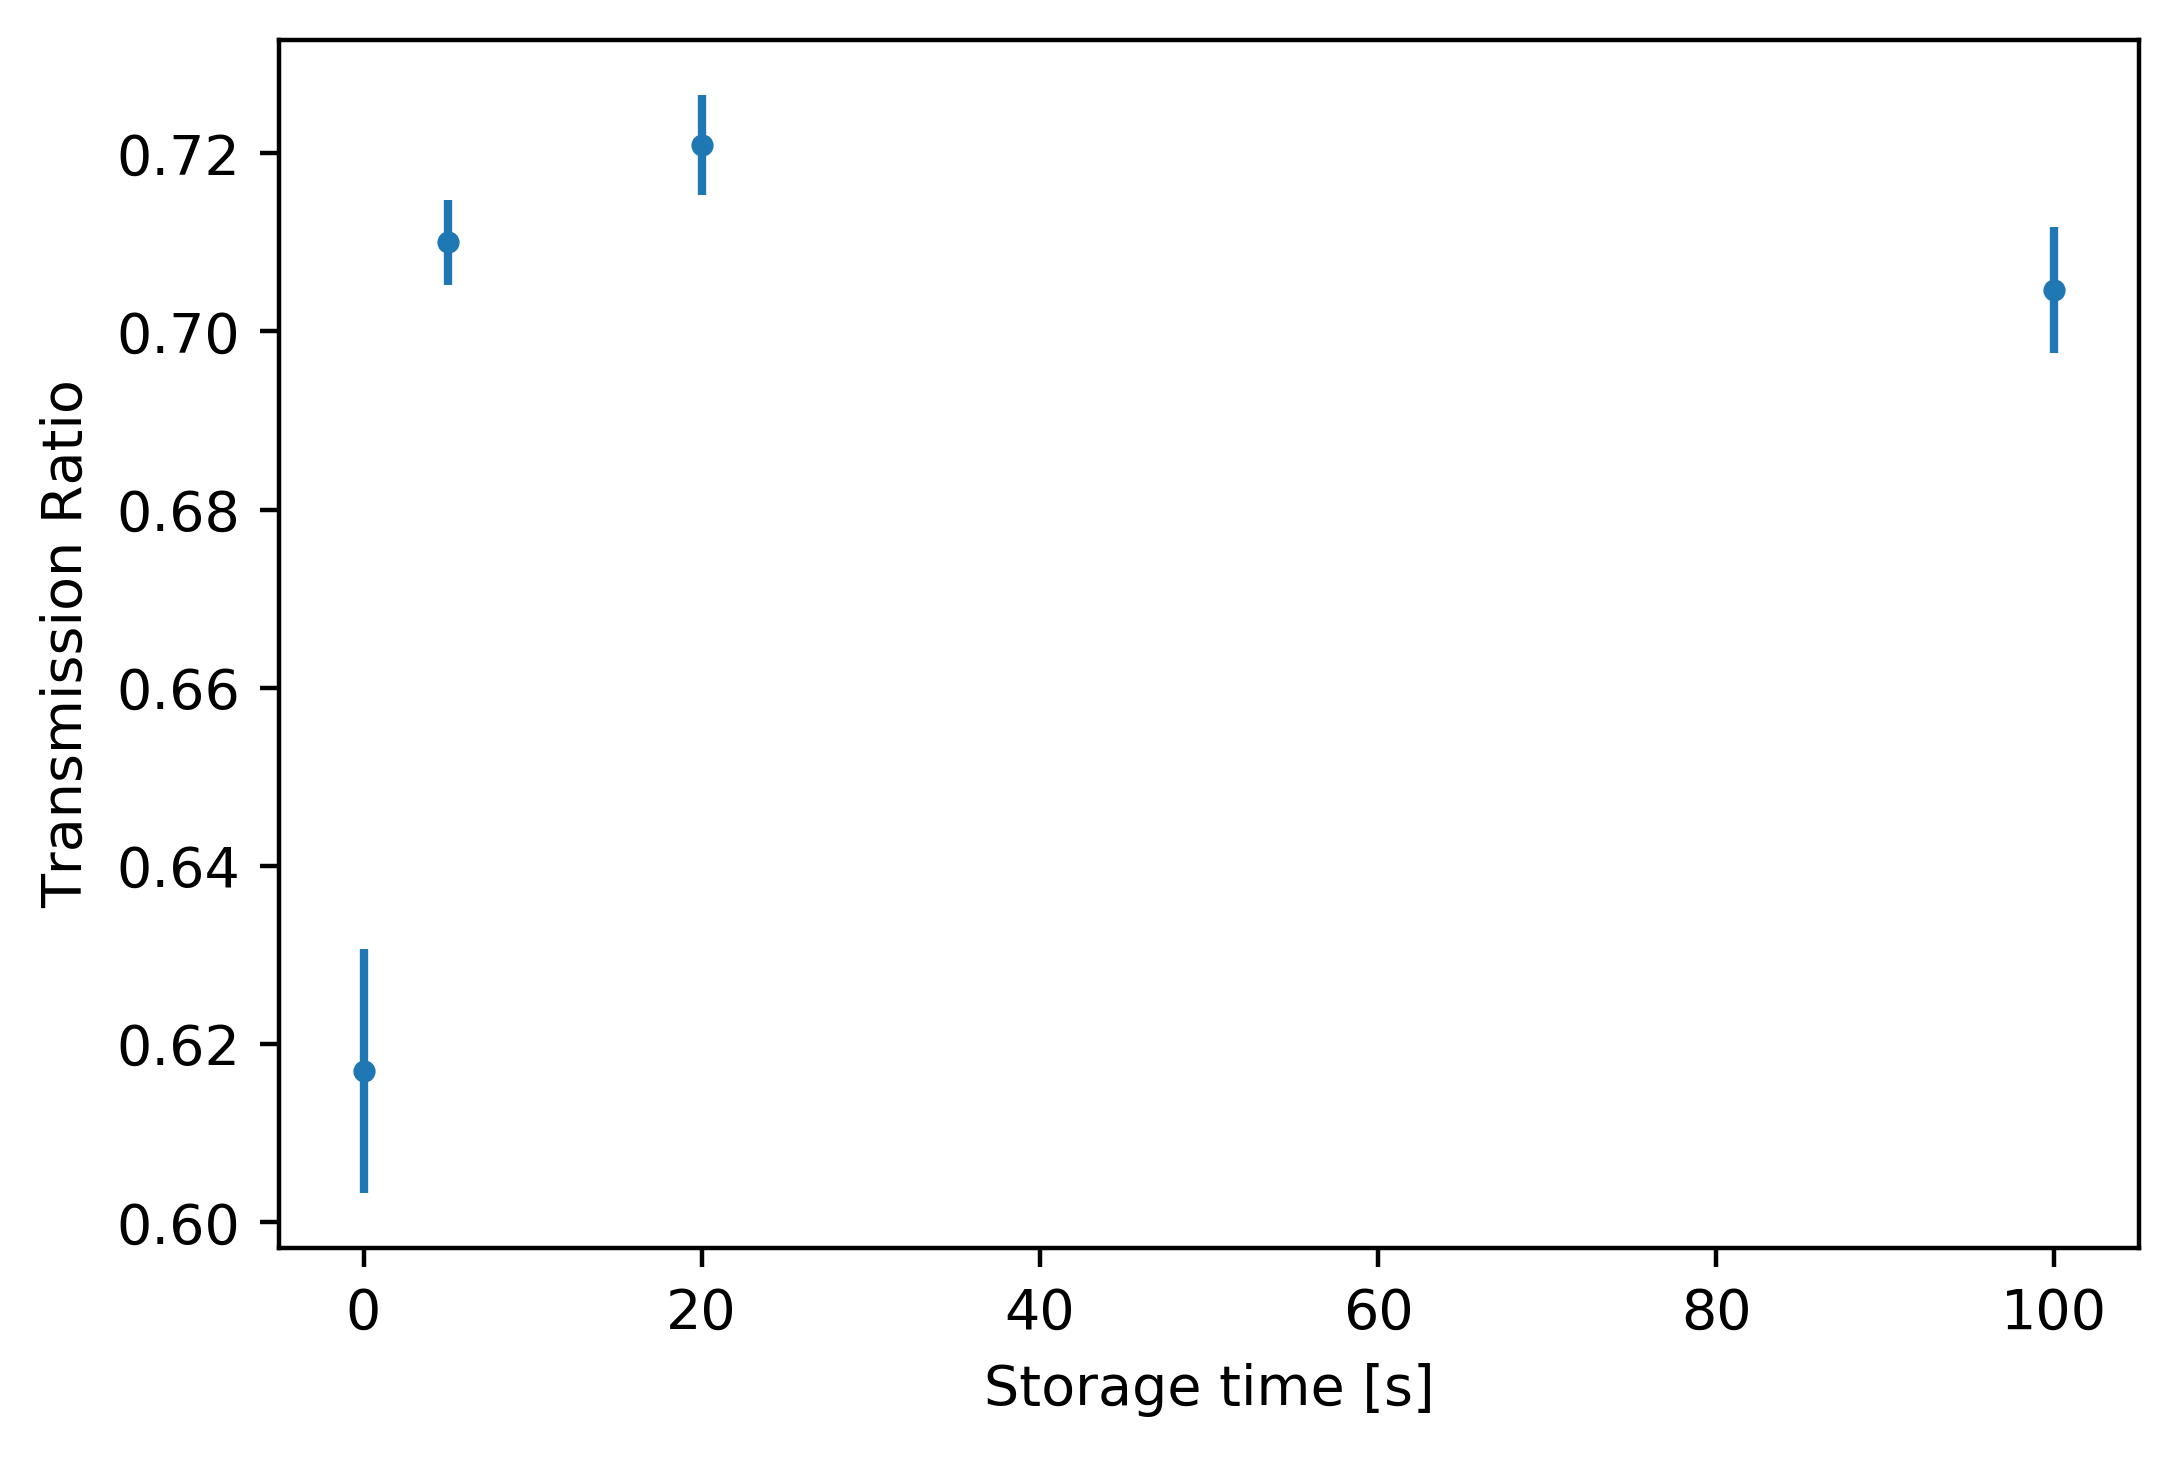

In [52]:
jpsu_transmission_results = transmission(jpsu_data_list)
jpsu_transmission_results

## JP Ti with NiP

array([[5.00000000e+00, 5.36717946e-01, 3.38364027e-03],
       [2.00000000e+01, 5.52730220e-01, 4.35045185e-03],
       [1.00000000e+02, 5.54911004e-01, 3.69640942e-03],
       [0.00000000e+00, 3.97040887e-01, 8.80097383e-03]])

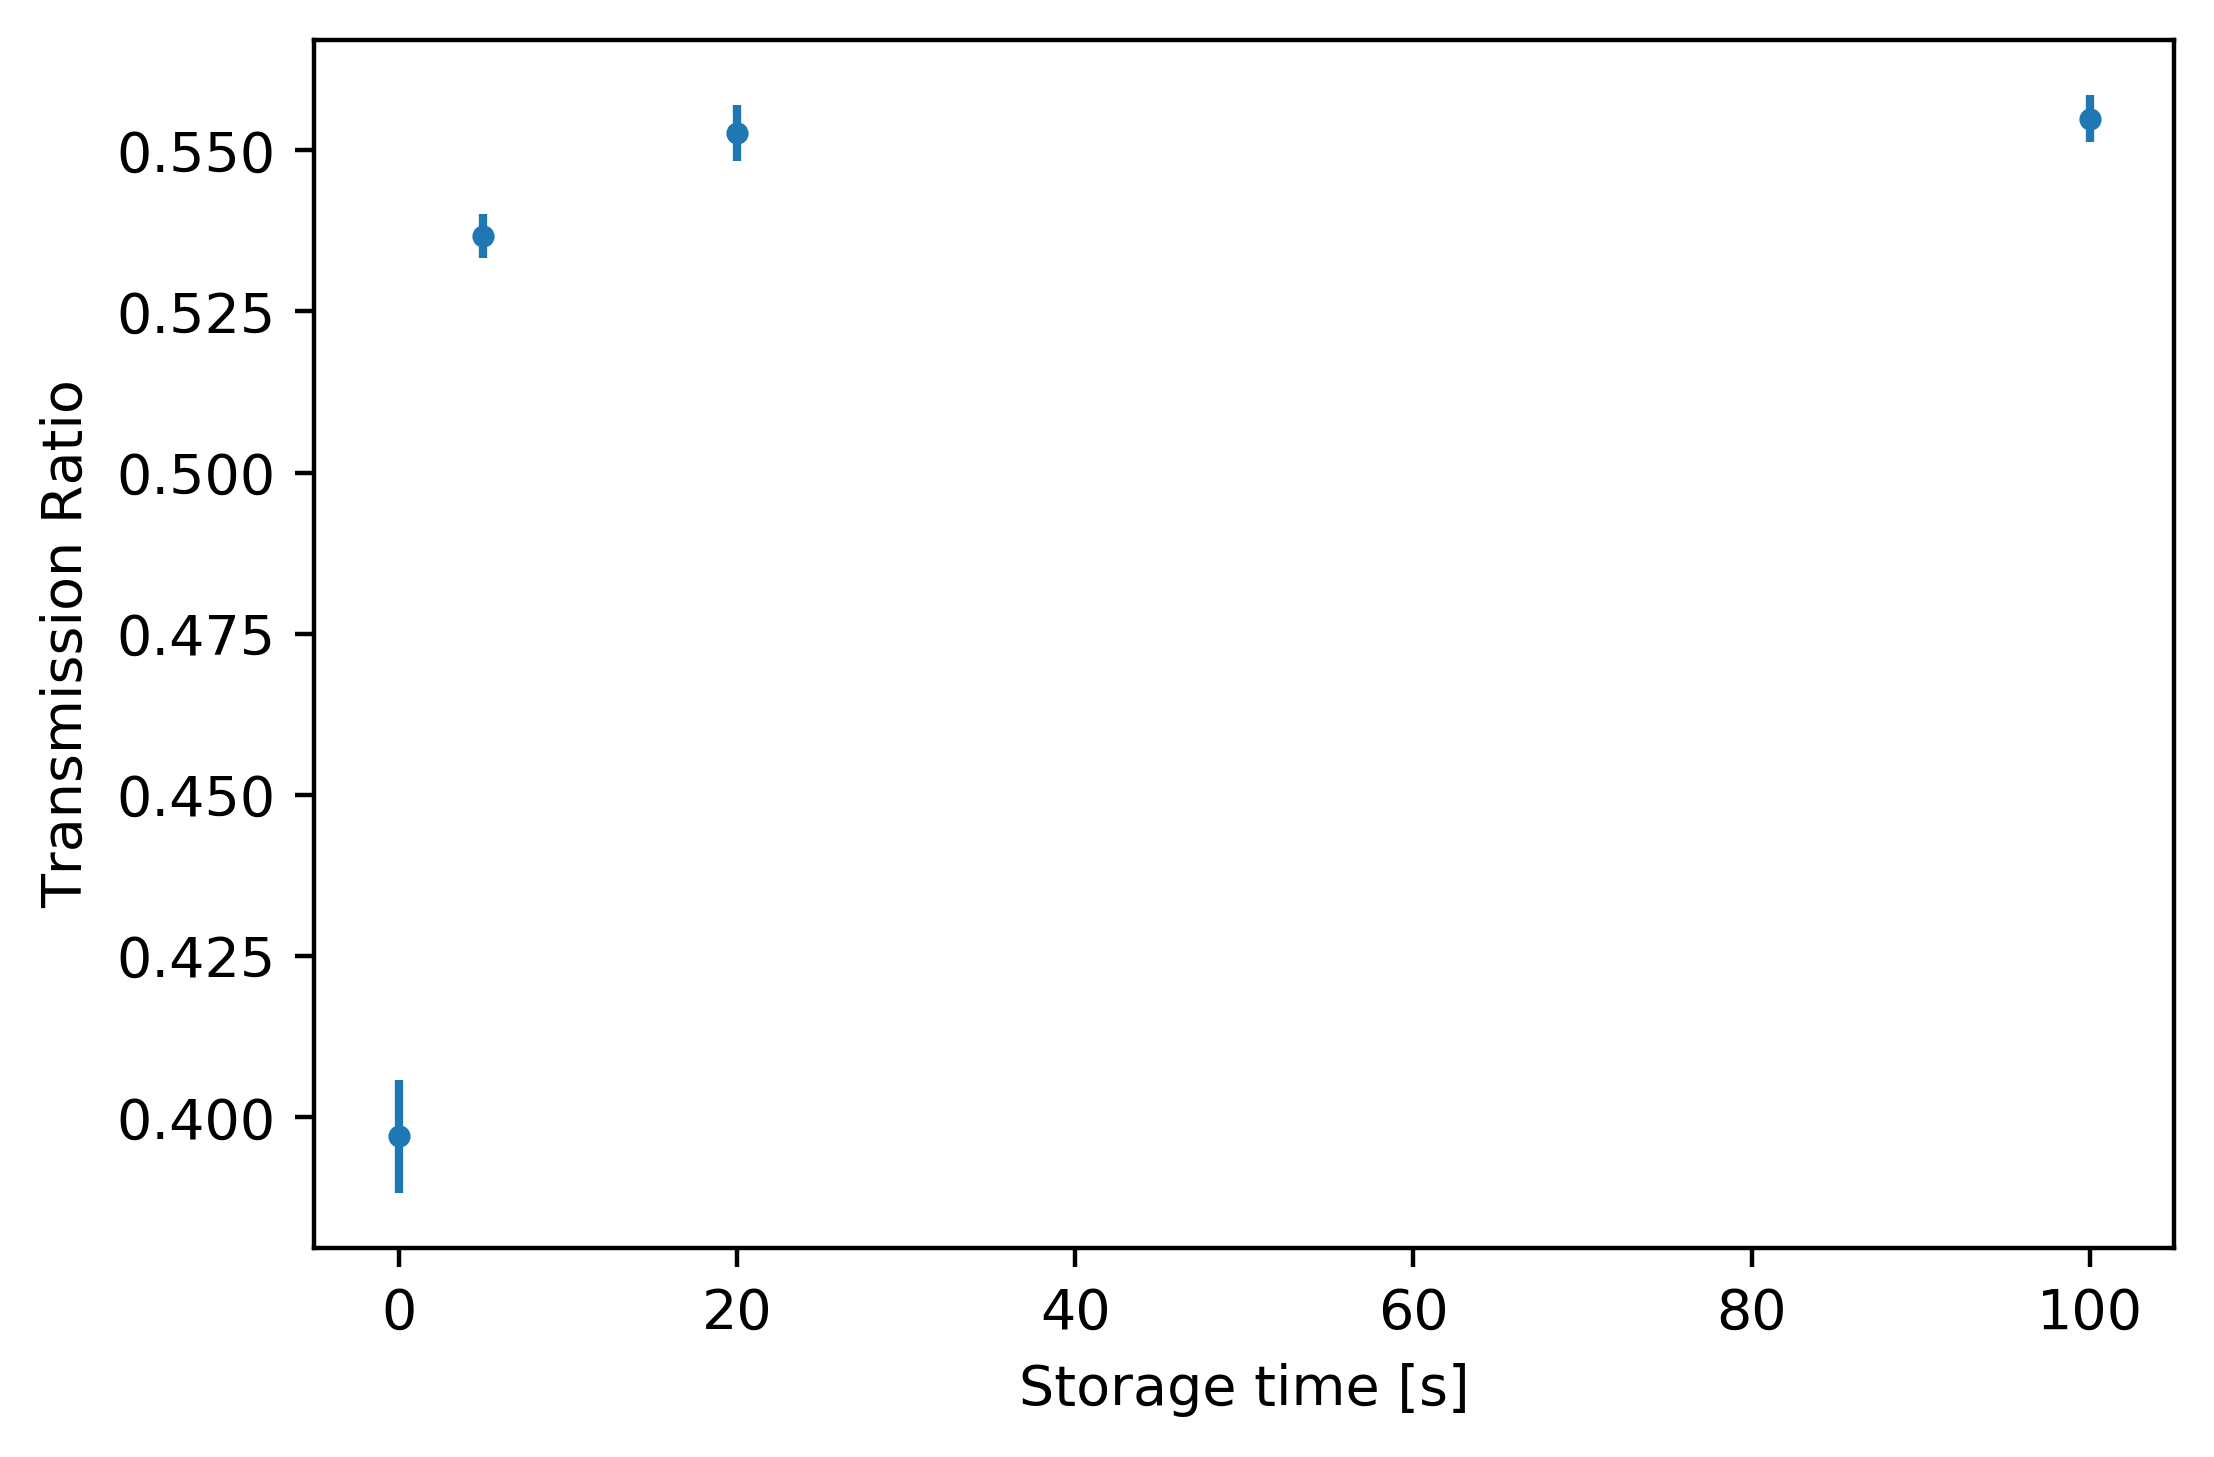

In [53]:
jpti_transmission_results = transmission(jpti_data_list)
jpti_transmission_results